# Quantum Social  Workers  Problem (SWP) Solver

Created by Parfait Atchade[2][3], 12 Dec 2019


### Contributors:
Parfait Atchade[2][3], Daniel Casado Faulí[1]

### Advisors:
Steve wood[1], 


#### Affiliation:
[1]IBM
[2]URL
[3]LDIG

## Problem Description 

We are given:
- A SAD (Visit Time) 
- A RANGE_TIMES (Time interval between schedules)
- A DES (Travel from visit to visit)
- A MAX_DIST (Limit distance between patients)
- A MAX_HOURS_CONTRACT ( Max hours / social worker contract)
- A MINUTES_DAY_CONTRACT (Hours per day not counting lunches (7.2 hours))
- A set of N_SOCIALWORKERS (N1, N2, N3...)
- A set of N_PATIENTS (P1, P2, P3...)
- A set of visits (U1, U2, U3...)
    - each visit is linked to a patient: a patient can have multiple visits on a day
    - for each visit, we know the start time and duration
- ~~A nurse can work at most 8 hours per day (that means, a nurse can not do a visit the first visit at 9:00 and end the last visit at 18:00)~~ (removed to reduce the number of variables, so this can be solved using Qiskit)
- We know the cost of traveling between each pair of patients. The cost can be seen as a function of travel time and distance.

The objective is the following:

- Find a schedule where each visit is assigned to a nurse
- We are minimizing the travel cost while also respecting that a nurse does not work more than 8 hours per day.

Thus, the Social Workers Problem (SWP) can be formulated as:

$$
(SWP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

with $w_{ij}$:

$$ w_{ij} = d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}, $$

where $w_{ij}$ is  the weight time window function,  $d_{ij}$ is the distance between the patient ${i}$ and the next ${j}$ and  $\left(\tau_i -\tau_j\right)^2$ is the time window's function. 


subject to the social worker-visiting constraint:

$$
\sum_{j \in \phi(i)^+} x_{ij} = 1, \,\forall i \in \{1,\dots,n\}, $$

where $\phi(i)^+$ is the outbound visits' set.  

$$
\sum_{j \in \phi(i)^-} x_{ji} = 1,\, \forall j \in \{1,\dots,n\},
$$

where $\phi(i)^-$ is the return visits' set.  


subject to the Workcenter-visiting constraints:

$$
\sum_{i \in \phi(0)^+} x_{0i} = K, $$

with K as the number of the available social workers 

$$ \sum_{j \in \phi(0)^+} x_{j0} = K,$$

with K as the number of the available social workers 


and subject to the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

The simplified SWP formulatio is:

$$SWP(\textbf{x})=\sum_{i,j}w_{ij}x_{ij}+ A\sum_{i \in \{1,\dots,n\}}\left(1- \sum_{j\in \phi(i)^+} x_{i,j}\right)^2+A\sum_{j \in \{1,\dots,n\}}\left(1- \sum_{i \in \phi(i)^-} x_{j,i}\right)^2 + A \Big(K-\sum_{i \in \phi(0)^+} x_{0i}\Big)^2 + A\Big(K-\sum_{j \in \phi(0)^+}  x_{j0} \Big)^2$$


So, the SWP math formulation with our time windows function is given by:

$$SWP(\textbf{x})=\sum_{i,j}\left(d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}\right)x_{ij}+ A\sum_{i \in \{1,\dots,n\}}\left(1- \sum_{j\in \phi(i)^+} x_{i,j}\right)^2+A\sum_{j \in \{1,\dots,n\}}\left(1- \sum_{i \in \phi(i)^-} x_{j,i}\right)^2 + A \Big(K-\sum_{i \in \phi(0)^+} x_{0i}\Big)^2 + A\Big(K-\sum_{j \in \phi(0)^+}  x_{j0} \Big)^2$$

With
$$A = 2*\mathrm{max}\left(w_{ij} = d_{ij} + \gamma \frac{\left(\tau_i -\tau_j\right)^2}{d_{max}- d_{min}}\right)$$



## Some results of SWP 
In this section we show some results of the algorithm and the different techniques and comparisons made.

#### One sample of SWP schedule
<img src="schedule.png" width="400" height="200"> 

#### SWP Matrix Distance
<img src="Matriz_distances.png" width="400" height="200"> 

#### SWP Results from Backtracking
<img src="BacktrackingSWP.png" width="400" height="200">

#### SWP Results from VQE
<img src="Quantum_Exact_Solver_SWP.png" width="400" height="200">

#### SWP Results from VQE
<img src="VQE_SWP.png" width="400" height="200">

#### SWP Benchmark 
<img src="Benchmark.png" width="400" height="200">

#### SWP Desviation analysis
<img src="Desviation.png" width="400" height="200">

#### SWP Results from OR-Tools
<img src="Ortools.png" width="400" height="200" name="Ortools">


In [50]:
from copy import copy, deepcopy
from datetime import datetime
from random import choice, randint
from math import floor
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import networkx as nx
import numpy as np
import sys

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from docplex.mp.model import Model
from qiskit import BasicAer
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
#from qiskit.optimization.ising import docplex
#from qiskit.optimization.ising.common import sample_most_likely

from qiskit.optimization.applications.ising import docplex
from qiskit.optimization.applications.ising.common import sample_most_likely

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG)
#from qiskit.aqua.translators.ising import docplex

# Visiting time
SAD = 60
# Time interval between schedules
RANGE_TIMES = 15
# Travel from visit to visit
DES = 10
# Limit distance between patients
MAX_DIST = 20
# Max hours / social worker contract
MAX_HOURS_CONTRACT = 1200
# Hours per day not counting lunches (7.2 hours)
MINUTES_DAY_CONTRACT = 450
# Number of patients in this test
N_PATIENTS = 5
# Number of social workers available is K
N_SOCIALWORKERS = 2
# Constant omega
OMEGA_CONSTANT = 0.7
#Weight to center (equal in both directions and constant)
ORIGIN_WEIGHT = 0
#Token IBMQ
TOKEN = '0cfab37f32ec2197a9f5e536d2a967d73a513303d76d41d5e7d7188267f1a715ee95d075605ced42f19e49664760106fda1dad2ecd06ce86cd35394f3a6c1992'
#%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
IBMQ.enable_account(TOKEN)

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# We create the table with patient schedules: 

In [3]:
# This class allows us to store the information of a time range of the schedule
class timeSchedule:
    def __init__(self, start, end):
        self.patients = []

        # Time schedule almacenado en formato Datetime
        self.timeStart = datetime.strptime(start, '%H:%M').time()
        self.timeEnd = datetime.strptime(end, '%H:%M').time()

        self.duration = subtractTimes(self.timeStart, self.timeEnd)

    def addPatient(self, patient):
        self.patients.append(patient)

    def getPatients(self):
        return self.patients

    def getOnePatient(self):
        return self.patients[0]

    def getStartTime(self):
        return self.timeStart

    def getEndTime(self):
        return self.timeEnd
    
    def getSchedule(self):
        return self.timeStart.strftime("%H:%M") + "-" + self.timeEnd.strftime("%H:%M")

    def getStartTimeMin(self):
        return (self.timeStart.hour * 60) + self.timeStart.minute

    def getEndTimeMin(self):
        return (self.timeEnd.hour * 60) + self.timeEnd.minute
    
    def getName(self):
        return self.patients[0]

# Standard table created manually
def createSchedule():
    schedules = {'M': [], 'T': [], 'W': [], 'TH': [], 'F': []}

    for columna in schedules:
        schedules[columna].append(timeSchedule('9:00', '10:00'))
        schedules[columna].append(timeSchedule('9:30', '10:30'))
        schedules[columna].append(timeSchedule('10:15', '11:15'))
        schedules[columna].append(timeSchedule('11:30', '12:30'))
        schedules[columna].append(timeSchedule('11:45', '12:45'))
        schedules[columna].append(timeSchedule('12:00', '13:00'))
        schedules[columna].append(timeSchedule('14:45', '15:45'))
        schedules[columna].append(timeSchedule('15:00', '16:00'))
        schedules[columna].append(timeSchedule('15:15', '16:15'))
        schedules[columna].append(timeSchedule('15:45', '16:45'))
        schedules[columna].append(timeSchedule('16:00', '17:00'))
        schedules[columna].append(timeSchedule('16:30', '17:30'))
        schedules[columna].append(timeSchedule('17:00', '18:00'))

    return schedules

# Subtraction of hours and minutes (taking into account the excess of the subtraction of minutes)
def subtractTimes(start, end):
    if end.minute >= start.minute:
        return ((end.hour - start.hour) * 60) + (end.minute - start.minute)
    else:
        return ((end.hour - start.hour) * 60) + (start.minute - end.minute)

# Function needed to perform sort in CreateRandomSchedule (createRamdomSchedule)
def takeStartTime(elem):
    return elem.getStartTime()


# nRows> 0
# rankMinimum / Maximum = allows us to specify start and end of the day
# Hours 1:00 p.m. to 2:30 p.m. reserved for lunch break
# Hours of operation of minimum duration Minimum and maximum duration Maximum
# Time range must be multiple of 5
def createRamdomSchedule(nRows, rangoMinimo, rangoMaximo):
    if nRows <= 0:
        return None

    schedules = {'M': [], 'T': [], 'W': [], 'TH': [], 'F': []}

    timeStart = datetime.strptime(rangoMinimo, '%H:%M').time()
    timeEnd = datetime.strptime(rangoMaximo, '%H:%M').time()

    duration = subtractTimes(timeStart, timeEnd)

    minutesStart = (timeStart.hour * 60) + timeStart.minute
    minutesEnd = (timeEnd.hour * 60) + timeEnd.minute
    
    
    #Check the limit hours that are multiples of 5
    if minutesStart % 5 != 0 or minutesEnd % 5 != 0:
        print("Error! Time range limit is not multiple of 5")
        return None


    # We create a list of minutes in a range of 5 min to perform a random search
    count = RANGE_TIMES
    randomNumbers = []
    while count <= duration:
        randomNumbers.append(count)
        count = count + RANGE_TIMES

    # We create a list of start minutes already chosen within the schedule
    listaStart = []

    i = 0
    while i < nRows:
        # We choose a random start time within the possibilities
        while True:
            randMinutesStart = minutesStart + choice(randomNumbers)

            if ((randMinutesStart <= 720) or (randMinutesStart >= 870)) and (
                    randMinutesStart <= minutesEnd - SAD) and (randMinutesStart not in listaStart):
                break

        # we add start minute to the list to avoid repeating
        listaStart.append(randMinutesStart)
        
        # In this scenario, we define and consider that the visit time is always constant
        randMinutesEnd = randMinutesStart + SAD
        
        # We add a new schedule to the final timeschedule
        for columna in schedules:
            schedules[columna].append(
                timeSchedule(str(floor(randMinutesStart / 60)) + ':' + str(floor(randMinutesStart % 60)),
                             str(floor(randMinutesEnd / 60)) + ':' + str(floor(randMinutesEnd % 60))))

        i = i + 1
    
    # we sort rows of the schedule so that it shows from the earliest to the latest
    for columna in schedules:
        schedules[columna].sort(key=takeStartTime)

    return schedules

## STEP
We fill in schedules with patients.

In [4]:
def fillSchedule(schedule):
    schedule['M'][0].addPatient(1)
    schedule['M'][1].addPatient(4)
    schedule['M'][4].addPatient(5)
    schedule['M'][5].addPatient(2)
    schedule['M'][8].addPatient(3)

    schedule['T'][0].addPatient(1)
    schedule['T'][6].addPatient(2)
    schedule['T'][11].addPatient(3)

    schedule['W'][0].addPatient(1)
    schedule['W'][2].addPatient(4)
    schedule['W'][9].addPatient(3)
    schedule['W'][10].addPatient(2)

    schedule['TH'][0].addPatient(1)
    schedule['TH'][7].addPatient(3)

    schedule['F'][0].addPatient(1)
    schedule['F'][3].addPatient(5)
    schedule['F'][3].addPatient(4)
    schedule['F'][12].addPatient(3)

# nTotalUsers <= nPatients * nPatients
def fillRamdomSchedule(schedule, nRows, nTotalUsers, nPatients):
    if nTotalUsers > nPatients * nPatients or nTotalUsers > (nRows * 2) * 5:
        print("Error, entered parameters do not allow fill in the table correctly!")
        return

    listaFechas = ['M', 'T', 'W', 'TH', 'F']

    i = 0
    while i < nTotalUsers:
        # We choose a day, an hour and a random patient to enter the schedule
        while True:
            day = choice(listaFechas)
            usuario = randint(1, nPatients)
            fila = randint(0, nRows - 1)

            #EXTRA OPTIONAL CONDITION: There cannot be more than two patients for the same hour. This way we avoid overlapping
            if len(schedule[day][fila].getPatients()) < 2:
                flag = 0
             
                # We check that the current patient has not already been entered at another or at the same time on the same day.
                for j in schedule[day]:
                    if usuario in j.getPatients():
                        flag = 1
                        break

                if flag == 0:
                    schedule[day][fila].addPatient(usuario)
                    break

        i = i + 1

## STEP

We print tables to show your result.

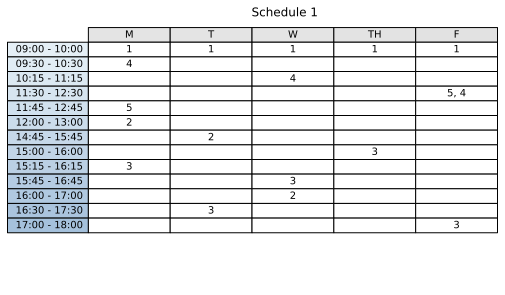

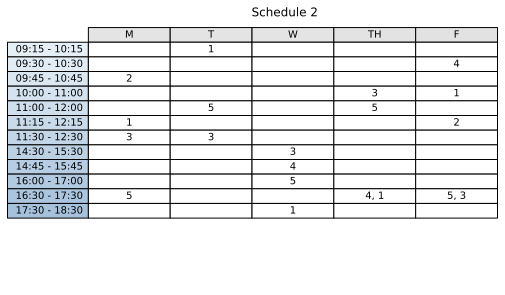

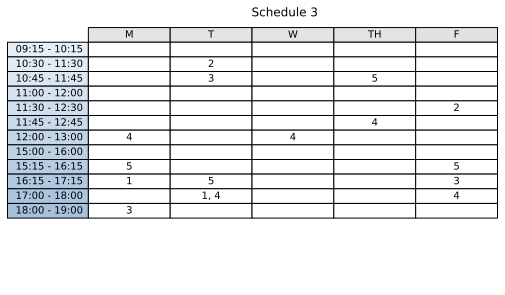

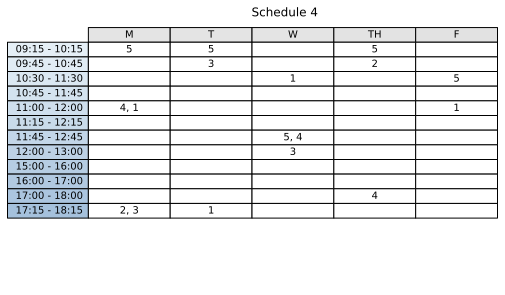

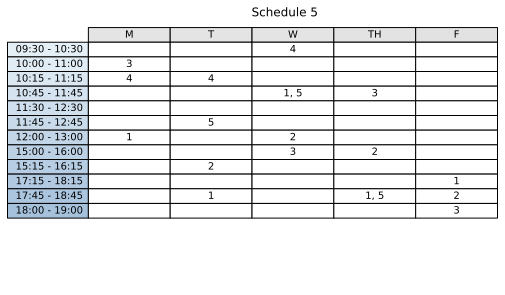

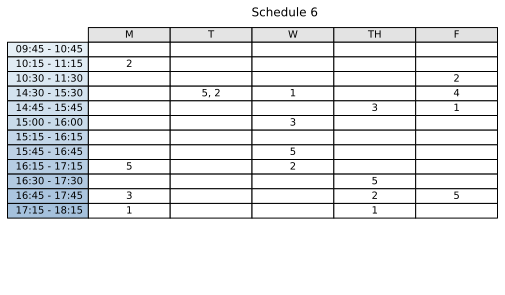

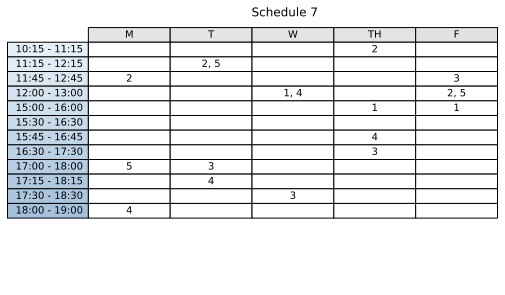

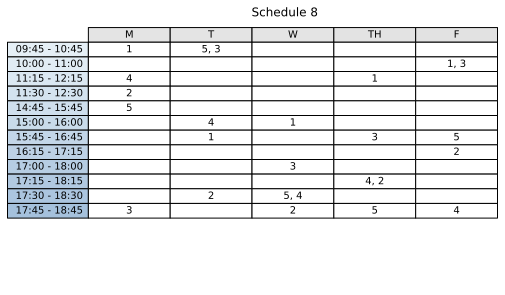

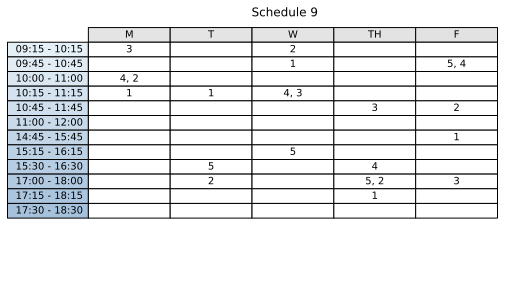

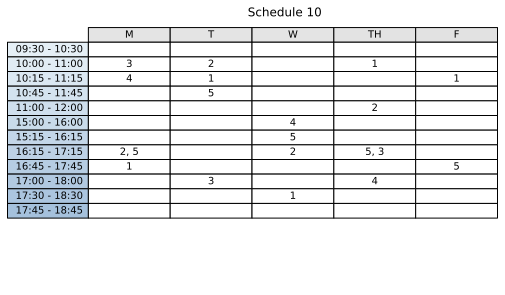

In [5]:
def plotScheduleTable(schedule, nschedule):
    columns = ('M', 'T', 'W', 'TH', 'F')
    rows = []

    for x in schedule['M']:
        rows.append(x.getStartTime().strftime("%H:%M") + " - " + x.getEndTime().strftime("%H:%M"))
    
    # We apply colors to row and column labels
    colorsRow = plt.cm.BuPu(np.linspace(0.1, 0.35, len(rows)))
    colorsColumn = plt.cm.Greys(np.linspace(0.19, 0.2, len(columns)))
    
    cell_text = []
    
    for row in range(len(rows)):
        fila = []
        
        for column in columns:
            fila.append(str(schedule[column][row].getPatients()).strip('[]'))
            
        cell_text.append(fila)
    
    fig, ax = plt.subplots()

    # We hide graph axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')  
    
    table = ax.table(cellText=cell_text,
              rowLabels=rows,
              rowColours=colorsRow,
              colLabels=columns,
            colColours=colorsColumn,
             cellLoc='center',
             loc='upper left')
    
    fig.tight_layout()
    plt.title('Schedule ' + str(nschedule))
    plt.show()
    

schedule1 = createSchedule()
fillSchedule(schedule1)
schedule2 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule2, len(schedule2['M']), 20, N_PATIENTS)
schedule3 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule3, len(schedule3['M']), 16, N_PATIENTS)
schedule4 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule4, len(schedule4['M']), 17, N_PATIENTS)
schedule5 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule5, len(schedule5['M']), 19, N_PATIENTS)
schedule6 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule6, len(schedule6['M']), 18, N_PATIENTS)
schedule7 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule7, len(schedule7['M']), 18, N_PATIENTS)
schedule8 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule8, len(schedule8['M']), 25, N_PATIENTS)
schedule9 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule9, len(schedule9['M']), 22, N_PATIENTS)
schedule10 = createRamdomSchedule(12, '9:00', '19:00')
fillRamdomSchedule(schedule10, len(schedule10['M']), 20, N_PATIENTS)

plotScheduleTable(schedule1, 1)
plotScheduleTable(schedule2, 2)
plotScheduleTable(schedule3, 3)
plotScheduleTable(schedule4, 4)
plotScheduleTable(schedule5, 5)
plotScheduleTable(schedule6, 6)
plotScheduleTable(schedule7, 7)
plotScheduleTable(schedule8, 8)
plotScheduleTable(schedule9, 9)
plotScheduleTable(schedule10, 10)   

## STEP
We create patient tables and their relationships:

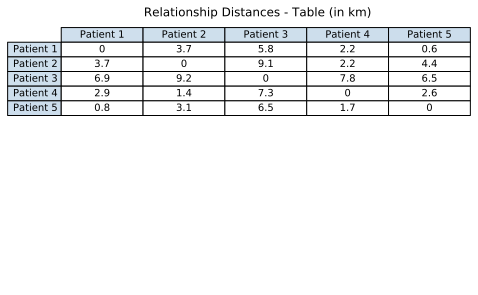

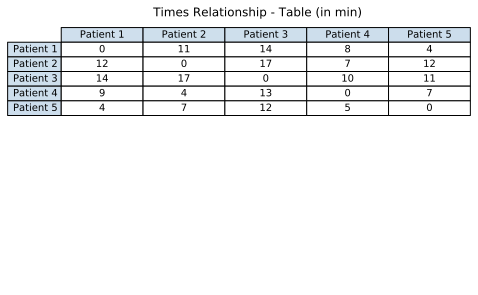

Patient 1: Carrer de Cros, 12, 08014 Barcelona
Patient 2: Calle Provenza, 256, 08008 Barcelona
Patient 3: Av. Mare de Déu de Bellvitge, 15, 08907 L'Hospitalet de Llobregat, Barcelona
Patient 4: Calle de Aragón, 100, 08015 Barcelona
Patient 5: Carrer de Leiva, 12, 08014 Barcelona


In [6]:
class Patient:
    def __init__(self, name, address):
        self.name = name
        self.address = address
        
    def getName(self):
        return self.name
    
    def getAddress(self):
        return self.address

class PatientRelationship:
    def __init__(self, time, distance, position):
        self.time = time
        self.distance = distance
        self.position = position
        
    def getTime(self):
        return self.time
    
    def getDistance(self):
        return self.distance
    
    def getPosition(self):
        return self.position

# First array: rows
# Second array: columns
def createPatientTable():
    table = [[PatientRelationship(0, 0, 0), PatientRelationship(12, 3.7, 1), PatientRelationship(14, 6.9, 2),
              PatientRelationship(9, 2.9, 3), PatientRelationship(4, 0.8, 4)],
             [PatientRelationship(11, 3.7, 5), PatientRelationship(0, 0, 6), PatientRelationship(17, 9.2, 7),
              PatientRelationship(4, 1.4, 8), PatientRelationship(7, 3.1, 9)],
             [PatientRelationship(14, 5.8, 10), PatientRelationship(17, 9.1, 11), PatientRelationship(0, 0, 12),
              PatientRelationship(13, 7.3, 13), PatientRelationship(12, 6.5, 14)],
             [PatientRelationship(8, 2.2, 15), PatientRelationship(7, 2.2, 16), PatientRelationship(10, 7.8, 17),
              PatientRelationship(0, 0, 18), PatientRelationship(5, 1.7, 19)],
             [PatientRelationship(4, 0.6, 20), PatientRelationship(12, 4.4, 21), PatientRelationship(11, 6.5, 22),
              PatientRelationship(7, 2.6, 23), PatientRelationship(0, 0, 24)]]

    return table


def createPatients():
    Patients = [Patient(1, "Carrer de Cros, 12, 08014 Barcelona"), Patient(2, "Calle Provenza, 256, 08008 Barcelona"),
                 Patient(3, "Av. Mare de Déu de Bellvitge, 15, 08907 L'Hospitalet de Llobregat, Barcelona"),
                 Patient(4, "Calle de Aragón, 100, 08015 Barcelona"), Patient(5, "Carrer de Leiva, 12, 08014 Barcelona")]
    return Patients

def plotPatientTables(tabla, Patients):
    labelRelations = []

    for x in Patients:
        labelRelations.append("Patient " + str(x.getName()))
    
    # Aplicamos colores a las etiquetas de filas y columnas
    colors = plt.cm.BuPu(np.linspace(0.19, 0.2, len(labelRelations)))
    
    cellTextDistance = []
    cellTextTime = []
    
    for row in range(len(labelRelations)):
        filaDistance = []
        filaTime = []
        
        for column in range(len(labelRelations)):
            filaDistance.append(str(tabla[column][row].getDistance()))
            filaTime.append(str(tabla[column][row].getTime()))
            
        cellTextDistance.append(filaDistance)
        cellTextTime.append(filaTime)
    
    fig, ax = plt.subplots()

     # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')  
    
    table = ax.table(cellText=cellTextDistance,
              rowLabels=labelRelations,
              rowColours=colors,
            colColours=colors,
              colLabels=labelRelations,
             cellLoc='center',
             loc='upper left')
    
    fig.tight_layout()
    plt.title('Relationship Distances - Table (in km)')
    plt.show()
    
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')  
    
    table = ax.table(cellText=cellTextTime,
              rowLabels=labelRelations,
              rowColours=colors,
            colColours=colors,
              colLabels=labelRelations,
             cellLoc='center',
             loc='upper left')
    
    fig.tight_layout()
    plt.title('Times Relationship - Table (in min)')
    plt.show()
    
    for patient in Patients:
        print("Patient " + str(patient.getName()) + ": " + patient.getAddress())
    

edges = createPatientTable()
Patients = createPatients()
plotPatientTables(edges, Patients)

EXTRA: To Plot our graphs, we define functions that isolate distances and times:

In [7]:
def getTimeMatrix(edges):
    table = []
    for row in range(len(edges)):
        _row = []
        for column in range(len(edges)):
            _row.append(edges[row][column].getTime())
            
        table.append(_row)
        
    return table

def getDistanceMatrix(edges):
    table = []
    for row in range(len(edges)):
        _row = []
        for column in range(len(edges)):
            _row.append(edges[row][column].getDistance())
            
        table.append(_row)
        
    return table

## STEP 
We define a function to plot our graphs based on node:

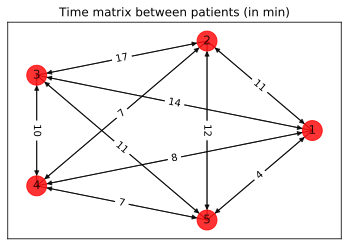

In [8]:
def plotGraph(nodes, edgesValues, edgesValid, colors, version, title):
    G = nx.DiGraph()
    
    elist = []    
    
    # We add the nodes that make up the graph
    for n in nodes:
        G.add_node(n.getName())
    
    # Obtenemos direccion y ejes validos del grafo
    for fila in range(len(edgesValid)):
        for columna in range(len(edgesValid[fila])):
            if(edgesValid[fila][columna] != 0):
                source = nodes[fila].getName()
                destiny = nodes[columna].getName()
                weight = edgesValues[fila][columna]
                elist.append([source, destiny, weight])
                
    # We obtain valid direction and axes of the graph
    G.add_weighted_edges_from(elist)
    
    if version == 'spring':
        pos=nx.spring_layout(G)
    elif version == 'circular':
        pos=nx.spring_layout(G)
    else:
        pos=nx.random_layout(G)
        
    pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
            
    #nodes_colors = ['r' for node in G.nodes()]
    nodes_colors = colors
    nx.draw_networkx(G,pos, node_color=nodes_colors, node_size=400, alpha=0.8)
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.title(title)
    
    
plotGraph(Patients, getTimeMatrix(edges), getTimeMatrix(edges), ['r' for node in Patients], 'circular', 'Time matrix between patients (in min)')

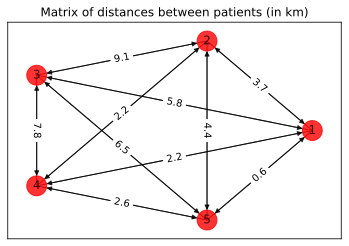

In [9]:
plotGraph(Patients, getDistanceMatrix(edges), getDistanceMatrix(edges), ['r' for node in Patients], 'circular', 'Matrix of distances between patients (in km)')

## STEP
Here, we calculate the minimum and maximum distances between patients:

In [10]:
newMax = 0
newMin = sys.maxsize
visitedResultMax = []
visitedResultMin = []


# Recursive backtracking algorithm that checks all possible cases from a point of origin
def findPath(i, visited):
    global newMax
    global newMin
    global visitedResultMax
    global visitedResultMin

    # CASE: All patients have already been visited
    if (len(visited) == len(Patients)):
        newDistance = 0

        # We add all the distances between patients visited
        for k in range(len(Patients) - 1):
            newDistance = newDistance + edges[visited[k]][visited[k + 1]].distance

        return newDistance

    else:
        # We pass (explore) all the vertices that the current vertex can direct.
        for j in edges[i]:
            # We do not go back into vertices that we have already visited
            if j.getPosition() % len(Patients) not in visited:
                # We make a new recursive call for each new vertex, adding it to visited before
                visited.append(j.getPosition() % len(Patients))
                newDistance = findPath(j.getPosition() % len(Patients), visited)

                # We see if the new distance obtained is better than the results already obtained
                if (newMax < newDistance):
                    newMax = newDistance
                    visitadosResultMax = visited[:]

                if (newMin > newDistance and newDistance != -1):
                    newMin = newDistance
                    visitedResultMin = visited[:]

                # We withdraw patient entered in previously visited
                visited.pop()

        return -1

# We execute the algorithm having as origin vertex, all the existing patients
for camino in range(len(Patients)):
    findPath(0, [camino])
    
print("Maximum distance: " + str(newMax))
print("Minimum distance: " + str(newMin))

Maximum distance: 23.2
Minimum distance: 10.6


## STEP
We define a function to calculate the least expensive itinerary based on weights and patients to visit.

This new formulation describes the temporal evolution of each social worker. Where W_ij is our cost / weight and time window function,  d_ij is the distance between the patient i and j and  f(t_ij) is our time window’s function.  f(t_ij) is a growing function and we model it by a quadratic function to weigh short distances in relation to large ones. Taking into account that the initial weight function W_ij=d_ij is a distance function, we want to make f(t_ij)  behave like d_ij, and thus, be able to take full advantage of the behaviour of the initial objective function. 
γ>0 It is a weighted degree parameter of our time window function; τ_i is the start time of a time slot for patient i and τ_j for the patient j. where d_max represents the maximum distance between all patients and, d_min is the minimum distance between the distances of all patients. The term T_ij=〖(τ〗_(i-) τ_j)>0 is the time window.


In [11]:
def calculateWeights(distancias, maxDistance, minDistance, visitas, vertices, pesos):
    for j in range(len(visitas)):
        for k in range(len(visitas)):
            # # We consider the weight of the way to headquarters/central/depot as 0
            if (k == 0 or j == 0) and k != j:
                vertices[j][k] = 1
                pesos[j][k] = ORIGIN_WEIGHT
            else:
                fila = visitas[j].getOnePatient() - 1
                columna = visitas[k].getOnePatient() - 1
                
               # Checks of different constrains of the problem (that there is no overlap, ...)
                if j != k and visitas[j].getEndTimeMin() < visitas[k].getStartTimeMin() \
                        and visitas[k].getStartTimeMin() - visitas[j].getStartTimeMin() <= 720 \
                        and visitas[k].getStartTimeMin() - visitas[j].getEndTimeMin() \
                                >= distancias[fila][columna].getTime():

                   # We mark as valid path
                    vertices[j][k] = 1
                    # Here we make the calculation of our new weights taking into account the time window of each visit.
                    #W_ij=d_ij+f(t_ij)
                    #f(t_ij )=γ(〖(τ〗_(i-) τ_j )^2)/(d_max-d_min )

                    pesos[j][k] = distancias[fila][columna].getDistance() + OMEGA_CONSTANT * (
                                pow((visitas[j].getStartTimeMin() - visitas[k].getStartTimeMin()), 2) / (
                                    maxDistance - minDistance))

## STEP
APPROXIMATION THAT WE WILL USE: Backtracking is not the most efficient algorithm to solve this problem but it is suitable for the type of CSP problem (Constraint Satisfaction Problems). Backtracking depends on user-given scenario that define the problem to be solved, the nature of the partial solutions, and how they are scaled into complete solutions. It is therefore a metaheuristic rather than a specific algorithm; it is guaranteed to find all solutions to a finite (limited) problem in a bounded amount of time since backtracking algorithms are generally exponential in both time and space

In our case, we use the Backtracking algorithm to consider all possible cases within the constraints.

In [12]:
def BacktrackingVehicleRouting(pesos, vertices, visitedNodes, solution, weightSolution, feasible, 
                                                   weightFeasible, nSocialWorkers, nPatients, nodeOrigin):    
    
    # CASE: We have already visited all patients in the current solution
    if nPatients == len(visitedNodes):
        if nSocialWorkers <= N_SOCIALWORKERS and weightSolution > weightFeasible:
            feasible[nSocialWorkers - 1].append(0)
            solution = deepcopy(feasible)
            weightSolution = weightFeasible
            feasible[nSocialWorkers - 1].pop()
    
    # Those patients that are missing to be visited
    else:
        if nodeOrigin == 0:
            path = [0]
            
            if nSocialWorkers + 1 <= N_SOCIALWORKERS:
                for initLoc in range(1, len(vertices)):
                    if (visitedNodes[initLoc - 1] == 0):
                        path.append(initLoc)
                        feasible.append(path)
                        visitedNodes[initLoc - 1] = 1

                        weightSolution, solution = BacktrackingVehicleRouting(pesos, vertices, visitedNodes,
                                                        solution, weightSolution, feasible, weightFeasible, 
                                                        nSocialWorkers + 1, nPatients + 1, initLoc)

                        feasible.remove(path)
                        path.remove(initLoc)
                        visitedNodes[initLoc - 1] = 0
                    
        else:            
            feasible[nSocialWorkers - 1].append(0)
            weightSolution, solution = BacktrackingVehicleRouting(pesos, vertices, visitedNodes, solution, 
                                                weightSolution, feasible, weightFeasible, nSocialWorkers, 
                                                nPatients, 0)
            
            feasible[nSocialWorkers - 1].pop()
                    
            for nodeDest in range(1, len(vertices[nodeOrigin])):
                if (visitedNodes[nodeDest - 1] == 0 and vertices[nodeOrigin][nodeDest] == 1):
                    feasible[nSocialWorkers - 1].append(nodeDest)
                    visitedNodes[nodeDest - 1] = 1
                    
                    if weightSolution > weightFeasible + pesos[nodeOrigin][nodeDest]:
                        weightSolution, solution = BacktrackingVehicleRouting(pesos, vertices, visitedNodes,
                                                            solution, weightSolution, feasible, 
                                                            weightFeasible + pesos[nodeOrigin][nodeDest], 
                                                            nSocialWorkers, nPatients + 1, nodeDest)
                    
                    feasible[nSocialWorkers - 1].remove(nodeDest)
                    visitedNodes[nodeDest - 1] = 0
                    
    return weightSolution, solution

## STEP
We create the most optimal different ways to reach all patients every day:

In [13]:
# This function will allow us to see the paths in tables
def plotWeights(table, patients, day):
    labelRelations = []

    for x in patients:
        labelRelations.append("Patient " + str(x.getName()))
    
    # We apply colors to row and column labels
    colors = plt.cm.BuPu(np.linspace(0.19, 0.2, len(labelRelations)))
    
    cellText = []
    
    for row in range(len(labelRelations)):
        fila = []
        
        for column in range(len(labelRelations)):
            fila.append(str(table[column][row]))
            
        cellText.append(fila)
    
    fig, ax = plt.subplots()

    # We hide the axes of the graph
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')  
    
    table = ax.table(cellText=cellText,
              rowLabels=labelRelations,
              rowColours=colors,
            colColours=colors,
              colLabels=labelRelations,
             cellLoc='center',
             loc='upper left')
    
    fig.tight_layout()
    plt.title('Weight Table ' + day)
    plt.show()

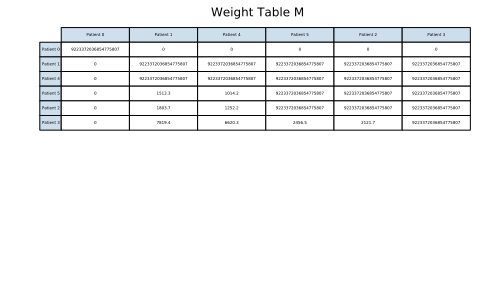

Elapsed time: 0.0002019405 seconds.


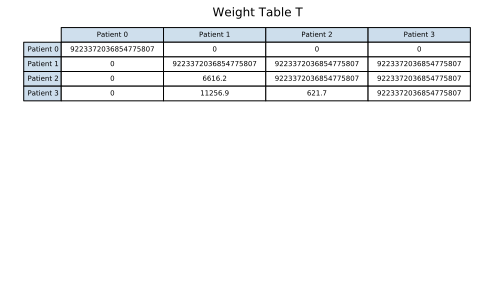

Elapsed time: 0.0000448227 seconds.


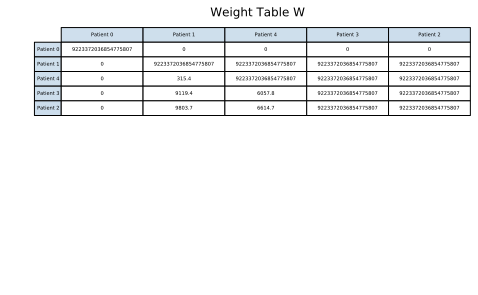

Elapsed time: 0.0000810623 seconds.


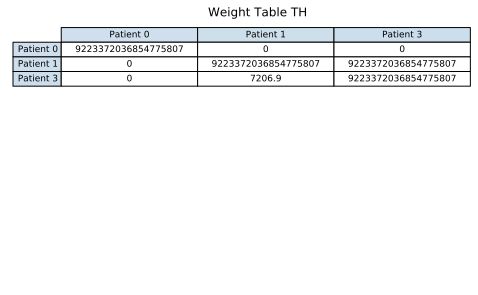

Elapsed time: 0.0001039505 seconds.


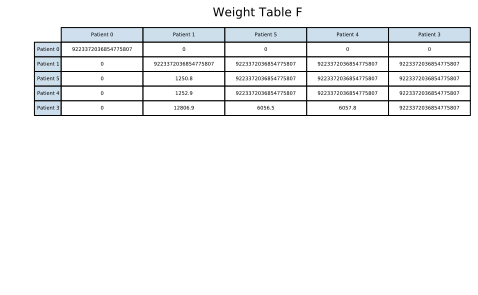

Elapsed time: 0.0001060963 seconds.


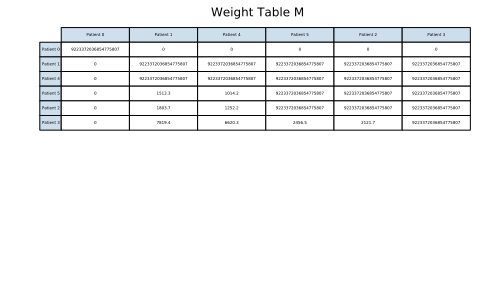

Elapsed time: 0.0002081394 seconds.


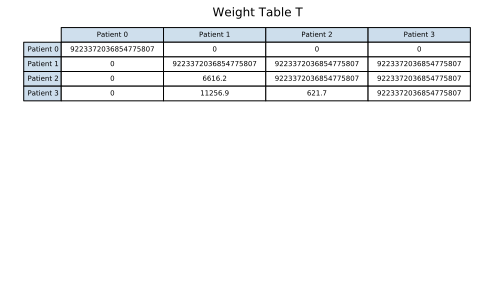

Elapsed time: 0.0000638962 seconds.


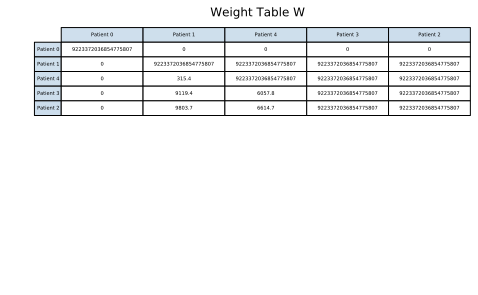

Elapsed time: 0.0000798702 seconds.


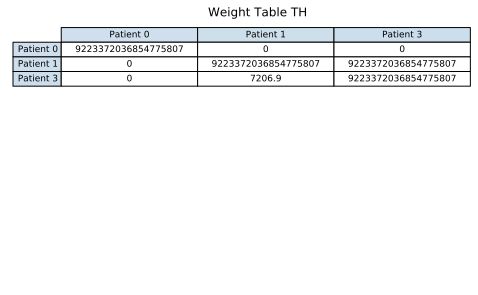

Elapsed time: 0.0000340939 seconds.


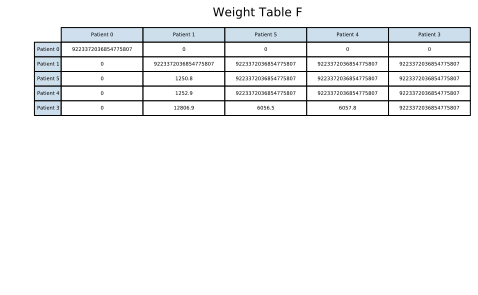

Elapsed time: 0.0001001358 seconds.


In [14]:
from time import time
def createPathsSocialWorkersBruteForce(schedule, distances, maxDistance, minDistance):
    SocialWorkerspaths = []
   
    # We run the algorithm for each day to plan each day of the week
    
    for day in schedule:
        patient0 = timeSchedule('9:00', '10:00')
        patient0.addPatient(0)
        visitas = [patient0]
        pathDay = []
        
        # we fill out an array with patients to visit from that day in order from earliest to latest
        for j in schedule[day]:
            for k in j.getPatients():
                visit = timeSchedule(j.getStartTime().strftime('%H:%M'), j.getEndTime().strftime('%H:%M'))
                visit.addPatient(k)
                visitas.append(visit)

        pesos = []
        vertices = []
        indexMatrix = []
        sumCosts = 0

        # We create two matrices, one with the weights and the other with the valid addresses between vertices (depending on the
        # order of patients, the former may be related to those who come after him)
        for j in range(len(visitas)):
            filaP = []
            filaV = []
            for k in range(len(visitas)):
                filaP.append(sys.maxsize)
                filaV.append(0)

            pesos.append(filaP)
            vertices.append(filaV)
        
        # We calculate weights taking into account the relationship between vertices previously explained
        
        calculateWeights(distances, maxDistance, minDistance, visitas, vertices, pesos)
        plotWeights(pesos, visitas, day)
        
        start_time = time()
        weightSolution, solution = BacktrackingVehicleRouting(pesos, vertices, [0 for i in range(len(vertices) - 1)], [], sys.maxsize, [], 0, 0, 0, 0)
        elapsed_time = time() - start_time
        print("Elapsed time: %0.10f seconds." % elapsed_time)
        
        SocialWorkerspaths.append([solution, weightSolution, visitas, pesos])
        
    return SocialWorkerspaths


SocialWorkerspaths = createPathsSocialWorkersBruteForce(schedule1, edges, newMax, newMin)
SocialWorkerspathsv10 = createPathsSocialWorkersBruteForce(schedule1, edges, newMax, newMin)

## STEP
We define function to plot format of the tour graph:

In [15]:
def plotGraphPaths(caminosEnfermeros, indice):
    size = len(caminosEnfermeros[indice][2])
    
    if (indice > 4):
        return "Error, there are only tours limited to the working days of the week!"
    
  
    # We create an empty matrix with the number of patients to visit in this way
    vertices = []
    for j in range(size):
        fila = []
        for i in range(size):
            fila.append(0)
        vertices.append(fila)
    
    colors = ['g' for i in range(size)]
    valid_colors = ['r','c','y','b','g']
    colors_count = 0
    nWorkers = 1
    # We map those paths in the matrix of valid axes that belong to the solution by connecting the patients in the order found in the solution.
    
    print("Social Worker TimeTable")
    print("----------------------------------")
    
    for camino in caminosEnfermeros[indice][0]:
        print("Social Worker " + str(nWorkers) + ":")
        
        for i in range(len(camino) - 1):
            if(i != 0):
                colors[camino[i]] = valid_colors[colors_count]
                print("\tPatient " + str(caminosEnfermeros[indice][2][camino[i]].getName()) + ": " + caminosEnfermeros[indice][2][camino[i]].getSchedule())
                
            vertices[camino[i]][camino[i + 1]] = 1
        
        colors_count = (colors_count + 1) % len(valid_colors)
        nWorkers = nWorkers + 1
                
    plotGraph(caminosEnfermeros[indice][2], caminosEnfermeros[indice][3], vertices, colors, 'spring', 'Our QSW Algorithm with Total weight: ' + str(caminosEnfermeros[indice][1]))

## STEP
Results for the Schedule 1 (Default) by using our Social Workers Algorithm by using backtracking.

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 5: 11:45-12:45
Social Worker 2:
	Patient 4: 09:30-10:30
	Patient 2: 12:00-13:00
	Patient 3: 15:15-16:15


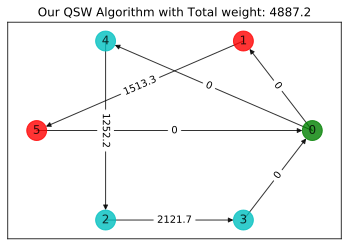

In [16]:
plotGraphPaths(SocialWorkerspaths, 0)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
Social Worker 2:
	Patient 2: 14:45-15:45
	Patient 3: 16:30-17:30


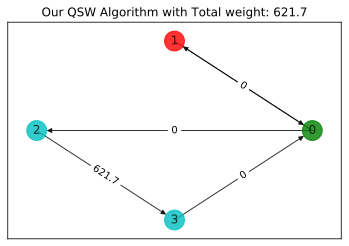

In [17]:
plotGraphPaths(SocialWorkerspaths, 1)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 4: 10:15-11:15
	Patient 3: 15:45-16:45
Social Worker 2:
	Patient 2: 16:00-17:00


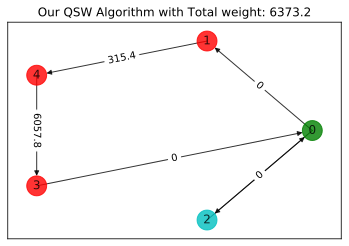

In [18]:
plotGraphPaths(SocialWorkerspaths, 2)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
Social Worker 2:
	Patient 3: 15:00-16:00


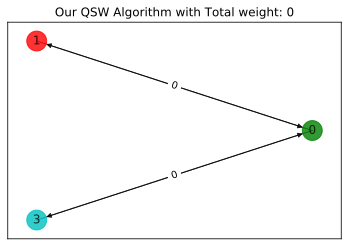

In [19]:
plotGraphPaths(SocialWorkerspaths, 3)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 5: 11:30-12:30
	Patient 3: 17:00-18:00
Social Worker 2:
	Patient 4: 11:30-12:30


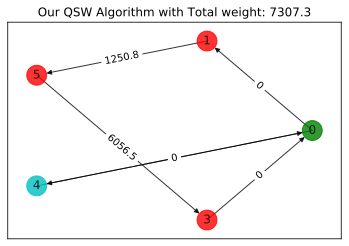

In [20]:
plotGraphPaths(SocialWorkerspaths, 4)

# Results for the Schedule 10 (Ramdom):

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 5: 11:45-12:45
Social Worker 2:
	Patient 4: 09:30-10:30
	Patient 2: 12:00-13:00
	Patient 3: 15:15-16:15


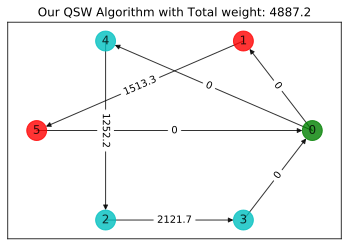

In [21]:
plotGraphPaths(SocialWorkerspathsv10, 0)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
Social Worker 2:
	Patient 2: 14:45-15:45
	Patient 3: 16:30-17:30


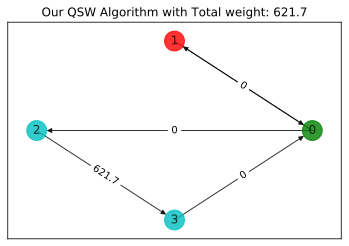

In [22]:
plotGraphPaths(SocialWorkerspathsv10, 1)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 4: 10:15-11:15
	Patient 3: 15:45-16:45
Social Worker 2:
	Patient 2: 16:00-17:00


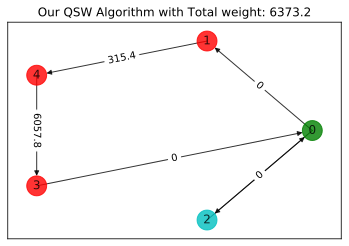

In [23]:
plotGraphPaths(SocialWorkerspathsv10, 2)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
Social Worker 2:
	Patient 3: 15:00-16:00


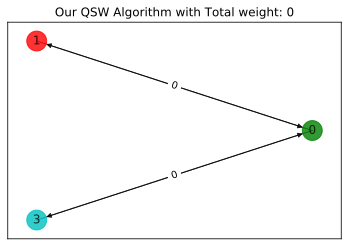

In [24]:
plotGraphPaths(SocialWorkerspathsv10, 3)

Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 5: 11:30-12:30
	Patient 3: 17:00-18:00
Social Worker 2:
	Patient 4: 11:30-12:30


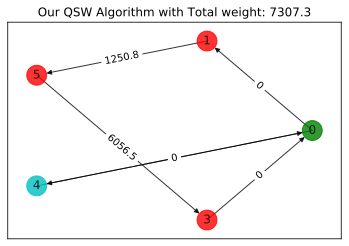

In [25]:
plotGraphPaths(SocialWorkerspathsv10, 4)

## STEP
Now we will carry out the same process but using Variational Quantum Eigensolver (VQE):

In [26]:
def VQEVehicleRouting(weights, nodes):
    n = len(nodes)
    
    # Create an instance of the model using the docplex
    mdl = Model(name='Social Workers Model')
    '''
    We define the binaries variables we will use to model our proposed problem.
    We check that the axis to which the binary variable refers is an axis that is valid from
    of the checks carried out in the calculation of weights (that schedules do not overlap, ...). Is
    check will be performed on each parameter of the model
    '''
    x = {(i,j): mdl.binary_var(name='x_{0}_{1}'.format(i,j)) for i in range(n) for j in range(n) 
                                                                                 if nodes[i][j] != 0}

    # Our Objective Function
    SWM_Objective_Function = mdl.sum(weights[i][j] * x[(i,j)] for i in range(n) for j in range(n) if nodes[i][j] != 0)
    mdl.minimize(SWM_Objective_Function)

    print("Social_Workers_function:\n",SWM_Objective_Function)

    # CONSTRAINTS:
    # A patient can only be visited only once a day
    for i in range(n):
        Const_ij=mdl.add_constraint(mdl.sum(x[(i,j)] for j in range(n) if nodes[i][j] != 0) == 1)
    print("mdl.add_constraint:\n",Const_ij)

    for j in range(n):
        Const_ji=mdl.add_constraint(mdl.sum(x[(i,j)] for i in range(n) if nodes[i][j] != 0) == 1)
    print("mdl.add_constraint:\n",Const_ji)
    
    # There must be the same number of paths that nurses have in the company
    Const_k_ij=mdl.add_constraint(mdl.sum(x[(0,i)] for i in range(n) if nodes[0][i] != 0) == N_SOCIALWORKERS)
    print("mdl.add_constraint:\n",Const_k_ij)
    Const_k_ji=mdl.add_constraint(mdl.sum(x[(j,0)] for j in range(n) if nodes[j][0] != 0) == N_SOCIALWORKERS)
    print("mdl.add_constraint:\n",Const_k_ji)
    print(mdl.export_to_string())
    mdl.print_information()
    
    return mdl

In [27]:
def createPathsSocialworkersVQE(horario, distancias, maxDistance, minDistance):
    SocialWorkerspaths = []

    # We run the algorithm for each day in order to plan each day of the week
    for day in horario:
        patient0 = timeSchedule('9:00', '10:00')
        patient0.addPatient(0)
        visitas = [patient0]
        pathDay = []
      
        # we fill in an array with the patients to visit of the day (considered) in order from earliest to latest
        for j in horario[day]:
            for k in j.getPatients():
                visit = timeSchedule(j.getStartTime().strftime('%H:%M'), j.getEndTime().strftime('%H:%M'))
                visit.addPatient(k)
                visitas.append(visit)

        pesos = []
        vertices = []
        indexMatrix = []
        sumCosts = 0

        # We create two matrices, one with the weights and the other with the valid addresses between vertices (depending on the
        # order of patients, the former may be related to those who come after him)
        for j in range(len(visitas)):
            filaP = []
            filaV = []
            for k in range(len(visitas)):
                filaP.append(sys.maxsize)
                filaV.append(0)

            pesos.append(filaP)
            vertices.append(filaV)

        # We calculate weights taking into account the relationship between vertices previously explained
        calculateWeights(distancias, maxDistance, minDistance, visitas, vertices, pesos)

        SocialWorkerspaths.append([VQEVehicleRouting(pesos, vertices), vertices, pesos, visitas])
    
    return SocialWorkerspaths

In [28]:
SocialWorkerspaths = createPathsSocialworkersVQE(schedule1, edges, newMax, newMin)

Social_Workers_function:
 1513.300x_1_3+1803.700x_1_4+7819.400x_1_5+1014.200x_2_3+1252.200x_2_4+6620.300x_2_5+2456.500x_3_5+2121.700x_4_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5+x_3_5+x_4_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 1513.300000000000 x_1_3 + 1803.700000000000 x_1_4
      + 7819.400000000000 x_1_5 + 1014.200000000000 x_2_3
      + 1252.200000000000 x_2_4 + 6620.300000000000 x_2_5
      + 2456.500000000000 x_3_5 + 2121.700000000000 x_4_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_3 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_3 + x_2_4 + x_2_5 = 1
 c4: x_3_0 + x_3_5 = 1
 c5: x_4_0 + x_4_5 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 = 1
 c10: x_0_3 + x_1_3 + x_2_3 = 1
 c11: x_0_4 + x_

## STEP
We make the calculation of our model by using the quantum ExactEigensolver. And after we will use the sample_most_likely to have the vector solution. Then, we will plot the graph with the different paths showed in different colors and we create a timetable for each social worker based on the results. We will follow this output format:

energy: -499459.44999999984

objective: 54091.80000000214

solution: [1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1]

Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
	Patient 5: 11:45-12:45
----------------------------------
Sociak Worker  2:
	Patient 4: 09:30-10:30
	Patient 2: 12:00-13:00
	Patient 3: 15:15-16:15
----------------------------------

In [29]:
def Quantum_ExactEigensolver(socialWorkersPath, day):
    columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    indice = columns.index(day)
    
    print('Result of ' + day + "'s "+'path')

    qubitOp, offset = docplex.get_operator(socialWorkersPath[indice][0])
    
    print('NUM Qubit/s= ',qubitOp.num_qubits)
    
    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()

    print('energy:', result['energy'])
    print('objective:', result['energy'] + offset)

    x = sample_most_likely(result['eigvecs'][0])
    print('solution:', x)
    
    #We create a solution matrix (axes between valid nodes as a solution) from the array that VQE returns.
    contador = 0
    
    edgesSolution = deepcopy(socialWorkersPath[indice][1])
    for k in range(len(edgesSolution)):
        for j in range(len(edgesSolution)):
            if edgesSolution[k][j] != 0:
              
                # We reuse the edgesValid matrix of socialWorkersPath to place the solution obtained:
                # Since we inserted the binary variables in the order that the possible axes appeared, we can re-map the results
                # of VQE to this again
                edgesSolution[k][j] = x[contador]
                contador = contador + 1
    
    valid_colors = ['r','c','y','b','g']
    colors_count = 0
    nWorkers = 1
    nodes_colors = ['g' for i in range(len(socialWorkersPath[indice][3]))]
    flag = True

    # We will print the social workers schedule while creating an array with the colors of each node
    # (since each node must have the color of the path it belongs to)
    print("Social Worker TimeTable")
    print("----------------------------------")
    for i in range(len(edgesSolution)):
        if edgesSolution[0][i] == 1:
            print("Sociak Worker  " + str(nWorkers) + ":")
            j = i
            
            while(j != 0):
                print("\tPatient " + str(socialWorkersPath[indice][3][j].getName()) + ": " + socialWorkersPath[indice][3][j].getSchedule())
                # We add the node to the current color (which means it belongs to the current path)
                nodes_colors[j] = valid_colors[colors_count]
                if 1 not in edgesSolution[j]:
                    break
                j = edgesSolution[j].index(1)
                
            colors_count = (colors_count + 1) % len(valid_colors)
            nWorkers = nWorkers + 1
            print("----------------------------------")
    
    plotGraph(socialWorkersPath[indice][3], socialWorkersPath[indice][2], edgesSolution, nodes_colors, 'spring', 'Result of ' + day +' by using Quantum ExactEigensolver')
    return [qubitOp, offset]

Result of Monday's path
NUM Qubit/s=  18


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


energy: -499459.44999999984
objective: 54091.80000000214
solution: [1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
	Patient 5: 11:45-12:45
----------------------------------
Sociak Worker  2:
	Patient 4: 09:30-10:30
	Patient 2: 12:00-13:00
	Patient 3: 15:15-16:15
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)


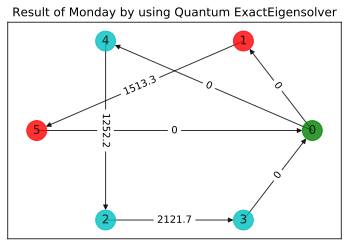

In [30]:
#ALL: Create optimal schedule in table for each nurse
qubitResult = []
qubitResult.append(Quantum_ExactEigensolver(SocialWorkerspaths, 'Monday'))

Result of Tuesday's path
NUM Qubit/s=  9
energy: -119600.49999999996
objective: 37613.299999999916
solution: [1 1 0 1 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
----------------------------------
Sociak Worker  2:
	Patient 2: 14:45-15:45
	Patient 3: 16:30-17:30
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

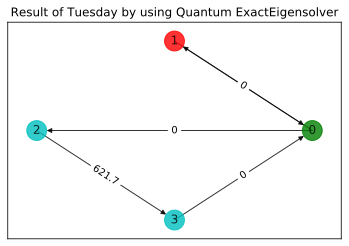

In [31]:
qubitResult.append(Quantum_ExactEigensolver(SocialWorkerspaths, 'Tuesday'))

Result of Wednesday's path
NUM Qubit/s=  13
energy: -360614.3
objective: 70197.20000000001
solution: [1 0 0 1 0 1 0 0 0 1 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
	Patient 4: 10:15-11:15
	Patient 3: 15:45-16:45
----------------------------------
Sociak Worker  2:
	Patient 2: 16:00-17:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

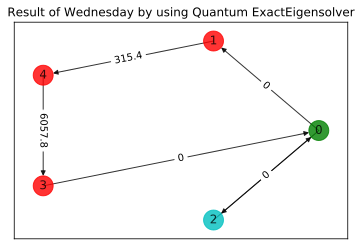

In [32]:
qubitResult.append(Quantum_ExactEigensolver(SocialWorkerspaths, 'Wednesday'))

Result of Thursday's path
NUM Qubit/s=  5
energy: -32435.049999999992
objective: 14415.79999999997
solution: [1 1 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
----------------------------------
Sociak Worker  2:
	Patient 3: 15:00-16:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

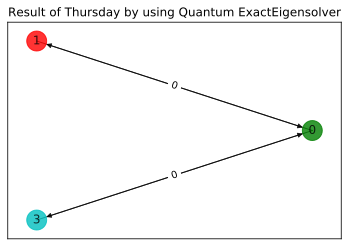

In [33]:
qubitResult.append(Quantum_ExactEigensolver(SocialWorkerspaths, 'Thursday'))

Result of Friday's path
NUM Qubit/s=  13
energy: -308090.05000000005
objective: 62159.099999999744
solution: [1 0 1 0 0 1 0 0 0 1 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:00-10:00
	Patient 5: 11:30-12:30
	Patient 3: 17:00-18:00
----------------------------------
Sociak Worker  2:
	Patient 4: 11:30-12:30
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

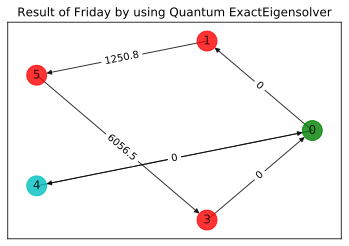

In [34]:
qubitResult.append(Quantum_ExactEigensolver(SocialWorkerspaths, 'Friday'))

In [35]:
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import COBYLA
def VQE_QASMSimulator(qubitResult, day, SocialWorkerspaths):
   # columns = ['M', 'T', 'W', 'TH', 'F']
    columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    indice = columns.index(day)
    
    seed = 10598
    #seed = 10598

    spsa = SPSA(max_trials=15)
    #ry = RY(qubitResult[indice][0].num_qubits, depth=5, entanglement='linear')
    ry = TwoLocal(qubitResult[indice][0].num_qubits, 'ry', 'cz', reps=5, entanglement='full')

    vqe = VQE(qubitResult[indice][0], ry, spsa)

    #spsa = SPSA(max_trials=300)
       # cobyla = COBYLA()
    #cobyla.set_options(maxiter=300)
    
    #ry = RY(qubitResult[indice][0].num_qubits, depth=5, entanglement='linear')
    #ry = TwoLocal(qubitResult[indice][0].num_qubits, 'ry', 'cz', reps=3, entanglement='full')
    
   # vqe = VQE(qubitResult[indice][0], ry, cobyla)

    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

    result = vqe.run(quantum_instance)

    x = sample_most_likely(result['eigvecs'][0])
    #x = sample_most_likely(result.eigenstate)
    
    #print ('energy',result.eigenvalue)
    #print ()
    
    print('energy:', result['energy'])
    print('time:', result['eval_time'])
    print('solution objective:', result['energy'] + qubitResult[indice][1])
    #print('opt params:', result['opt_params'])
    print('solution:', x)
    
    #Creamos matriz solucion (ejes entre nodos válidos como solución) a partir del array que nos devuelve VQE
    contador = 0
    
    for k in range(len(SocialWorkerspaths[indice][1])):
        for j in range(len(SocialWorkerspaths[indice][1])):
            if SocialWorkerspaths[indice][1][k][j] != 0:
                # Reutilizamos matriz edgesValid de socialWorkersPath para colocar la solución obtenida:
                # Ya que insertamos las variables binarias en el orden que aparecian los ejes posibles, podemos volver a mapear los resultadosos
                # de VQE a esta de nuevo
                SocialWorkerspaths[indice][1][k][j] = x[contador]
                contador = contador + 1
    
    valid_colors = ['r','c','y','b','g']
    colors_count = 0
    nWorkers = 1
    nodes_colors = ['g' for i in range(len(SocialWorkerspaths[indice][3]))]
    flag = True
    
    # Printaremos horario de social workers mientras creamos array con los colores de cada nodo
    # (ya que cada nodo debe tener el color del camino al que pertence)
    print("Social Worker TimeTable")
    print("----------------------------------")
    for i in range(len(SocialWorkerspaths[indice][1])):
        if SocialWorkerspaths[indice][1][0][i] == 1:
            print("Social Worker " + str(nWorkers) + ":")
            j = i
            
            while(j != 0):
                print("\tPatient " + str(SocialWorkerspaths[indice][3][j].getName()) + ": " + SocialWorkerspaths[indice][3][j].getSchedule())
                # Agregamos el nodo al color actual (lo que significa que pertenece al camino actual)
                nodes_colors[j] = valid_colors[colors_count]
                if 1 not in SocialWorkerspaths[indice][1][j]:
                    break
                j = SocialWorkerspaths[indice][1][j].index(1)
                
            colors_count = (colors_count + 1) % len(valid_colors)
            nWorkers = nWorkers + 1
            print("----------------------------------")
    
    plotGraph(SocialWorkerspaths[indice][3], SocialWorkerspaths[indice][2], SocialWorkerspaths[indice][1], nodes_colors, 'spring', 'Result of ' + day +' by using VQE QASM_Simulator')
 
    return result['opt_params']

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use opti

energy: 3969.170410156241
time: 389.1579201221466
solution objective: 557520.4204101582
solution: [1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
----------------------------------
Social Worker 2:
	Patient 4: 09:30-10:30
----------------------------------
Social Worker 3:
	Patient 2: 12:00-13:00
----------------------------------
Social Worker 4:
	Patient 3: 15:15-16:15
----------------------------------


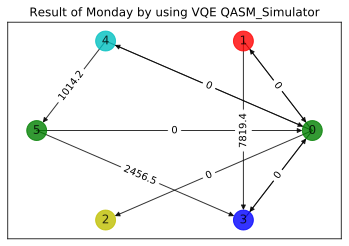

In [36]:
params = []
params.append(VQE_QASMSimulator(qubitResult, 'Monday', SocialWorkerspaths))

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  DeprecationWarning)


energy: -24976.21484375
time: 12.102335929870605
solution objective: 132237.58515624987
solution: [1 0 0 0 1 0 1 0 0]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 2: 14:45-15:45
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

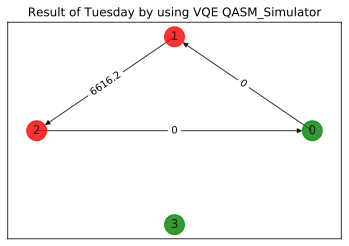

In [37]:
params.append(VQE_QASMSimulator(qubitResult, 'Tuesday', SocialWorkerspaths))

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  DeprecationWarning)


energy: -27678.0302734375
time: 66.97107100486755
solution objective: 403133.4697265625
solution: [1 0 0 0 0 0 1 1 1 0 0 1 0]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 3: 15:45-16:45
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

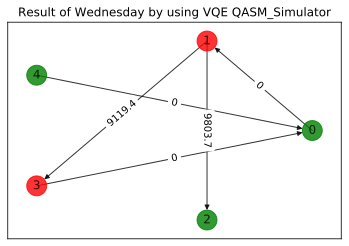

In [38]:
params.append(VQE_QASMSimulator(qubitResult, 'Wednesday', SocialWorkerspaths))

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  DeprecationWarning)


energy: -9692.640917968747
time: 0.9737329483032227
solution objective: 37158.209082031215
solution: [1 1 1 0 0]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
----------------------------------
Social Worker 2:
	Patient 3: 15:00-16:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

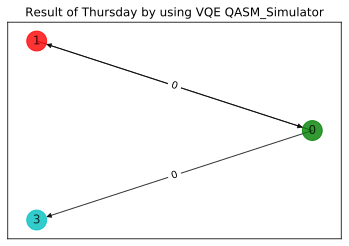

In [39]:
params.append(VQE_QASMSimulator(qubitResult, 'Thursday', SocialWorkerspaths))

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  DeprecationWarning)


energy: -15952.281445312507
time: 67.31607913970947
solution objective: 354296.8685546873
solution: [1 1 0 1 0 1 0 1 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 09:00-10:00
	Patient 5: 11:30-12:30
----------------------------------
Social Worker 2:
	Patient 5: 11:30-12:30
----------------------------------
Social Worker 3:
	Patient 3: 17:00-18:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

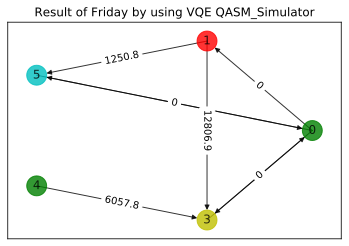

In [40]:
params.append(VQE_QASMSimulator(qubitResult, 'Friday', SocialWorkerspaths))

# COMPARATIVE GRAPHS:

We obtain results from the rest of the hours:

In [41]:
def createScheduleResults(scheduleAlt, edges, newMax, newMin):
    socialWorkersPathsAlt = createPathsSocialworkersVQE(scheduleAlt, edges, newMax, newMin)
    qubitResultAlt = []
    qubitResultAlt.append(Quantum_ExactEigensolver(socialWorkersPathsAlt, 'Monday'))
    qubitResultAlt.append(Quantum_ExactEigensolver(socialWorkersPathsAlt, 'Tuesday'))
    qubitResultAlt.append(Quantum_ExactEigensolver(socialWorkersPathsAlt, 'Wednesday'))
    qubitResultAlt.append(Quantum_ExactEigensolver(socialWorkersPathsAlt, 'Thursday'))
    qubitResultAlt.append(Quantum_ExactEigensolver(socialWorkersPathsAlt, 'Friday'))
    
    paramsAlt = []
    paramsAlt.append(VQE_QASMSimulator(qubitResultAlt, 'Monday', socialWorkersPathsAlt))
    return paramsAlt



Social_Workers_function:
 453.700x_1_2+621.700x_1_3+9115.600x_1_4+5513.300x_2_4+5006.500x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 453.700000000000 x_1_2 + 621.700000000000 x_1_3 + 9115.600000000000 x_1_4
      + 5513.300000000000 x_2_4 + 5006.500000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Result of Thursday's path
NUM Qubit/s=  12
energy: -290173.25000000006
objective: 72542.50000000093
solution: [1 1 0 0 0 1 0 0 0 1 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 3: 10:00-11:00
	Patient 4: 16:30-17:30
----------------------------------
Sociak Worker  2:
	Patient 5: 11:00-12:00
	Patient 1: 16:30-17:30
----------------------------------
Result of Friday's path
NUM Qubit/s=  18


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

energy: -979383.5000000003
objective: 111559.99999999569
solution: [1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 09:30-10:30
	Patient 2: 11:15-12:15
	Patient 5: 16:30-17:30
----------------------------------
Sociak Worker  2:
	Patient 1: 10:00-11:00
	Patient 3: 16:30-17:30
----------------------------------
energy: -36971.325976562504
time: 65.07586932182312
solution objective: 242637.4740234383
solution: [0 1 1 0 0 1 1 0 1 0 1 0 0]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 1: 11:15-12:15
----------------------------------
Social Worker 2:
	Patient 3: 11:30-12:30
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 2114.200x_1_2+3614.700x_1_3+7207.800x_1_4+1519x_2_4+619.400x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2114.200000000000 x_1_2 + 3614.700000000000 x_1_3
      + 7207.800000000000 x_1_4 + 1519 x_2_4 + 619.400000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Social_Workers_function:
 2815.600x_1_2+4521.700x_1_3+6051.400x_1_4+615.100x_2_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2815.600000000000 x_1_2 + 4521.700000000000 x_1_3
      + 6051.400000000000 x_1_4 + 615.100000000000 x_2_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -709026.4
objective: 195299.0999999959
solution: [0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 3: 10:45-11:45
	Patient 1: 17:00-18:00
----------------------------------
Sociak Worker  2:
	Patient 4: 17:00-18:00
----------------------------------
Result of Wednesday's path
NUM Qubit/s=  2
energy: -5.0
objective: 2.0
solution: [1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 12:00-13:00
----------------------------------
Result of Thursday's path
NUM Qubit/s=  4
energy: -4.0
objective: 2.0
solution: [1 1 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 5: 10:45-11:45
----------------------------------
Sociak Worker  2:
	Patient 4: 11:45-12:45
----------------------------------
Result of Friday's path
NUM Qubit/s=  12
energy: -143619.19999999998
objective: 31440.29999999996
solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Social Worke

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 615.100x_1_2+613.100x_1_3+12804.400x_1_4+12806.500x_1_5+7814.700x_2_4+7820.300x_2_5+7816.200x_3_4+7819.400x_3_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5+x_3_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 615.100000000000 x_1_2 + 613.100000000000 x_1_3 + 12804.400000000000 x_1_4
      + 12806.500000000000 x_1_5 + 7814.700000000000 x_2_4
      + 7820.300000000000 x_2_5 + 7816.200000000000 x_3_4
      + 7819.400000000000 x_3_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_4 + x_2_5 = 1
 c4: x_3_0 + x_3_4 + x_3_5 = 1
 c5: x_4_0 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 + x_1_2 = 1
 c10: x_0_3 + x_1_3 = 1
 c11: x_0_4 + x_1_4 + 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 0
mdl.add_constraint:
 x_2_0 == 1
mdl.add_constraint:
 x_0_2 == 1
mdl.add_constraint:
 x_0_1+x_0_2 == 2
mdl.add_constraint:
 x_1_0+x_2_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj:
Subject To
 c1: x_0_1 + x_0_2 = 1
 c2: x_1_0 = 1
 c3: x_2_0 = 1
 c4: x_1_0 + x_2_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 = 1
 c7: x_0_1 + x_0_2 = 2
 c8: x_1_0 + x_2_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_2_0 <= 1

Binaries
 x_0_1 x_0_2 x_1_0 x_2_0
End

Model: Social Workers Model
 - number of variables: 4
   - binary=4, integer=0, continuous=0
 - number of constraints: 8
   - linear=8
 - parameters: defaults
 - objective: none
 - problem type is: MILP
Result of Monday's path
NUM Qubit/s=  18


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -1175021.6500000001
objective: 132468.60000000615
solution: [1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 5: 09:15-10:15
	Patient 1: 11:00-12:00
	Patient 3: 17:15-18:15
----------------------------------
Sociak Worker  2:
	Patient 4: 11:00-12:00
	Patient 2: 17:15-18:15
----------------------------------
Result of Tuesday's path
NUM Qubit/s=  8
energy: -133088.10000000003
objective: 59370.60000000024
solution: [1 1 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 5: 09:15-10:15
----------------------------------
Sociak Worker  2:
	Patient 3: 09:45-10:45
	Patient 1: 17:15-18:15
----------------------------------
Result of Wednesday's path
NUM Qubit/s=  11
energy: -8379.000000000002
objective: 4659.699999999964
solution: [1 0 1 0 0 1 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 10:30-11:30
	Patient 5:

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 805.800x_1_3+614.700x_2_3
mdl.add_constraint:
 x_3_0 == 1
mdl.add_constraint:
 x_0_3+x_1_3+x_2_3 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 805.800000000000 x_1_3 + 614.700000000000 x_2_3
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 = 1
 c2: x_1_0 + x_1_3 = 1
 c3: x_2_0 + x_2_3 = 1
 c4: x_3_0 = 1
 c5: x_1_0 + x_2_0 + x_3_0 = 1
 c6: x_0_1 = 1
 c7: x_0_2 = 1
 c8: x_0_3 + x_1_3 + x_2_3 = 1
 c9: x_0_1 + x_0_2 + x_0_3 = 2
 c10: x_1_0 + x_2_0 + x_3_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_3 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_3 <= 1
 0 <= x_3_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_1_0 x_1_3 x_2_0 x_2_3 x_3_0
End

Model: Social Workers Model
 - number of variables: 8
   - binary=8, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: de

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Social_Workers_function:
 0
mdl.add_constraint:
 x_3_0 == 1
mdl.add_constraint:
 x_0_3 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj:
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 = 1
 c2: x_1_0 = 1
 c3: x_2_0 = 1
 c4: x_3_0 = 1
 c5: x_1_0 + x_2_0 + x_3_0 = 1
 c6: x_0_1 = 1
 c7: x_0_2 = 1
 c8: x_0_3 = 1
 c9: x_0_1 + x_0_2 + x_0_3 = 2
 c10: x_1_0 + x_2_0 + x_3_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_1_0 x_2_0 x_3_0
End

Model: Social Workers Model
 - number of variables: 6
   - binary=6, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: none
 - problem type is: MILP
Result of Monday's path
NUM Qubit/s=  8
energy: -7913.8
objective: 3457.7
solution: [1 1 0 1 0 0 1 1]
Social Wo

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

energy: -385213.10000000003
objective: 37680.80000000144
solution: [1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 09:30-10:30
	Patient 5: 10:45-11:45
----------------------------------
Sociak Worker  2:
	Patient 1: 10:45-11:45
	Patient 2: 12:00-13:00
	Patient 3: 15:00-16:00
----------------------------------
Result of Thursday's path
NUM Qubit/s=  13
energy: -296929.3499999999
objective: 57670.59999999893
solution: [1 0 1 0 0 1 0 0 0 0 1 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 3: 10:45-11:45
	Patient 2: 15:00-16:00
	Patient 5: 17:45-18:45
----------------------------------
Sociak Worker  2:
	Patient 1: 17:45-18:45
----------------------------------
Result of Friday's path
NUM Qubit/s=  6
energy: -3.0
objective: 4.0
solution: [1 0 1 1 1 0]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 17:15-18:15
-----------------

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 7203.100x_1_2+8459.200x_1_3+9803.700x_1_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7203.100000000000 x_1_2 + 8459.200000000001 x_1_3
      + 9803.700000000001 x_1_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Social_Workers_function:
 3201.400x_1_2+3616.200x_1_3+7815.600x_1_4+1014.200x_2_4+800.800x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 3201.400000000000 x_1_2 + 3616.200000000000 x_1_3
      + 7815.600000000000 x_1_4 + 1014.200000000000 x_2_4
      + 800.800000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 + x_1_2 = 1
 c9: x_0_3 + x_1_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <=

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

NUM Qubit/s=  13
energy: -185163.10000000003
objective: 36900.59999999945
solution: [1 0 1 0 0 1 0 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 10:30-11:30
	Patient 4: 14:30-15:30
----------------------------------
Sociak Worker  2:
	Patient 1: 14:45-15:45
	Patient 5: 16:45-17:45
----------------------------------
energy: -21488.5810546875
time: 33.75384783744812
solution objective: 284114.9189453125
solution: [1 0 1 0 0 1 1 0 1 0 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 2: 10:15-11:15
	Patient 5: 16:15-17:15
----------------------------------
Social Worker 2:
	Patient 3: 16:45-17:45
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 5515.600x_1_2+7813.900x_1_3
mdl.add_constraint:
 x_3_0 == 1
mdl.add_constraint:
 x_0_3+x_1_3 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5515.600000000000 x_1_2 + 7813.900000000000 x_1_3
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 = 1
 c2: x_1_0 + x_1_2 + x_1_3 = 1
 c3: x_2_0 = 1
 c4: x_3_0 = 1
 c5: x_1_0 + x_2_0 + x_3_0 = 1
 c6: x_0_1 = 1
 c7: x_0_2 + x_1_2 = 1
 c8: x_0_3 + x_1_3 = 1
 c9: x_0_1 + x_0_2 + x_0_3 = 2
 c10: x_1_0 + x_2_0 + x_3_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_3_0
End

Model: Social Workers Model
 - number of variables: 8
   - binary=8, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: defa

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Social_Workers_function:
 2118.300x_1_4+1803.700x_2_4+1800.600x_3_4
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4+x_1_4+x_2_4+x_3_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 2118.300000000000 x_1_4 + 1803.700000000000 x_2_4
      + 1800.600000000000 x_3_4
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 + x_1_4 = 1
 c3: x_2_0 + x_2_4 = 1
 c4: x_3_0 + x_3_4 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 = 1
 c10: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_4 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_4 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_4 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

solution: [1 0 1 0 0 1 0 0 0 1 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 10:15-11:15
	Patient 1: 15:00-16:00
	Patient 3: 16:30-17:30
----------------------------------
Sociak Worker  2:
	Patient 4: 15:45-16:45
----------------------------------
Result of Friday's path
NUM Qubit/s=  11
energy: -43987.70000000001
objective: 24695.00000000013
solution: [0 1 1 0 1 0 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 12:00-13:00
----------------------------------
Sociak Worker  2:
	Patient 5: 12:00-13:00
	Patient 1: 15:00-16:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

energy: -6980.395507812498
time: 6.281627893447876
solution objective: 99663.1044921875
solution: [0 1 1 0 0 1 1 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 5: 17:00-18:00
----------------------------------
Social Worker 2:
	Patient 4: 18:00-19:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 452.900x_1_2+616.200x_1_3+5000.800x_1_4+12806.900x_1_5+2451.700x_2_4+8457.800x_2_5+2115.600x_3_4+7821.700x_3_5+1806.500x_4_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5+x_3_5+x_4_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 452.900000000000 x_1_2 + 616.200000000000 x_1_3 + 5000.800000000000 x_1_4
      + 12806.900000000000 x_1_5 + 2451.700000000000 x_2_4
      + 8457.799999999999 x_2_5 + 2115.600000000000 x_3_4
      + 7821.700000000000 x_3_5 + 1806.500000000000 x_4_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_2 + x_1_3 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_4 + x_2_5 = 1
 c4: x_3_0 + x_3_4 + x_3_5 = 1
 c5: x_4_0 + x_4_5 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 + x_1_

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 6613.300x_1_3+7816.200x_1_4+12015.400x_1_5+6619x_2_3+7821.600x_2_4+12019.800x_2_5+802.600x_3_5+451.400x_4_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5+x_3_5+x_4_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 6613.300000000000 x_1_3 + 7816.200000000000 x_1_4
      + 12015.400000000000 x_1_5 + 6619 x_2_3 + 7821.600000000000 x_2_4
      + 12019.799999999999 x_2_5 + 802.600000000000 x_3_5
      + 451.400000000000 x_4_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_3 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_3 + x_2_4 + x_2_5 = 1
 c4: x_3_0 + x_3_5 = 1
 c5: x_4_0 + x_4_5 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 = 1
 c10: x_0_3 + x_1_3 + x_2_3 = 1
 c11: x_0_4 + x_1_4 + x_2_4 = 1
 

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -909308.6999999998
objective: 87437.20000000519
solution: [1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 09:45-10:45
	Patient 4: 11:15-12:15
----------------------------------
Sociak Worker  2:
	Patient 2: 11:30-12:30
	Patient 5: 14:45-15:45
	Patient 3: 17:45-18:45
----------------------------------
Result of Tuesday's path
NUM Qubit/s=  18


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -1039321.4999999999
objective: 116035.00000000547
solution: [1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 5: 09:45-10:45
	Patient 1: 15:45-16:45
	Patient 2: 17:30-18:30
----------------------------------
Sociak Worker  2:
	Patient 3: 09:45-10:45
	Patient 4: 15:00-16:00
----------------------------------
Result of Wednesday's path
NUM Qubit/s=  14
energy: -59540.100000000006
objective: 29773.699999999633
solution: [0 0 1 1 0 0 1 0 0 0 0 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 5: 17:30-18:30
----------------------------------
Sociak Worker  2:
	Patient 4: 17:30-18:30
----------------------------------
Result of Thursday's path
NUM Qubit/s=  17


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

energy: -496653.8000000003
objective: 119066.99999999837
solution: [1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 11:15-12:15
	Patient 3: 15:45-16:45
	Patient 4: 17:15-18:15
----------------------------------
Sociak Worker  2:
	Patient 5: 17:45-18:45
----------------------------------
Result of Friday's path
NUM Qubit/s=  18


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be re

energy: -1095399.3500000003
objective: 123206.89999999409
solution: [1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 10:00-11:00
	Patient 5: 15:45-16:45
----------------------------------
Sociak Worker  2:
	Patient 3: 10:00-11:00
	Patient 2: 16:15-17:15
	Patient 4: 17:45-18:45
----------------------------------
energy: -139516.17900390623
time: 714.441593170166
solution objective: 857229.7209960988
solution: [0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 5: 14:45-15:45
----------------------------------
Social Worker 2:
	Patient 3: 17:45-18:45
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 0
mdl.add_constraint:
 x_4_0 == 1
mdl.add_constraint:
 x_0_4 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj:
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 1
 c2: x_1_0 = 1
 c3: x_2_0 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 1
 c7: x_0_1 = 1
 c8: x_0_2 = 1
 c9: x_0_3 = 1
 c10: x_0_4 = 1
 c11: x_0_1 + x_0_2 + x_0_3 + x_0_4 = 2
 c12: x_1_0 + x_2_0 + x_3_0 + x_4_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_0_4 <= 1
 0 <= x_1_0 <= 1
 0 <= x_2_0 <= 1
 0 <= x_3_0 <= 1
 0 <= x_4_0 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_0_4 x_1_0 x_2_0 x_3_0 x_4_0
End

Model: Social Workers Model
 - number of variables: 8
   - binary=8, integer=0, continuous=0
 - number of constraints: 12
   - linear=12
 - parameters: defaults
 - objective: none
 - problem typ

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates 

Social_Workers_function:
 5000.600x_1_4+10519x_1_5+5002.200x_2_4+10520.300x_2_5+3203.700x_3_4+7821.700x_3_5+1019.400x_4_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5+x_3_5+x_4_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 5000.600000000000 x_1_4 + 10519 x_1_5 + 5002.200000000000 x_2_4
      + 10520.299999999999 x_2_5 + 3203.700000000000 x_3_4
      + 7821.700000000000 x_3_5 + 1019.400000000000 x_4_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_4 + x_2_5 = 1
 c4: x_3_0 + x_3_4 + x_3_5 = 1
 c5: x_4_0 + x_4_5 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 = 1
 c10: x_0_3 = 1
 c11: x_0_4 + x_1_4 + x_2_4 + x_3_4 = 1
 c12: x_0_5 + x_1_5 + x_2_5 + x_3_5 + x_4_5 = 1
 c13: x_0_1

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


energy: -285786.55
objective: 144580.30000000092
solution: [1 0 1 0 0 1 0 0 0 0 1 1 0 0]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 09:15-10:15
----------------------------------
Sociak Worker  2:
	Patient 4: 10:15-11:15
	Patient 5: 15:15-16:15
----------------------------------
Result of Thursday's path
NUM Qubit/s=  17


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -522404.49999999977
objective: 125514.70000000065
solution: [0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 17:00-18:00
----------------------------------
Sociak Worker  2:
	Patient 1: 17:15-18:15
----------------------------------
Result of Friday's path
NUM Qubit/s=  17


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/spsa.py:98: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be re

energy: -749814.6500000005
objective: 176574.69999999576
solution: [0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 09:45-10:45
----------------------------------
Sociak Worker  2:
	Patient 2: 10:45-11:45
	Patient 1: 14:45-15:45
	Patient 3: 17:00-18:00
----------------------------------
energy: -0.07421875
time: 7.1546409130096436
solution objective: 9.92578125
solution: [0 1 0 0 0 0 0 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 4: 10:00-11:00
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

Social_Workers_function:
 7821.600x_1_3+7819x_1_4+9118.300x_1_5+7202.200x_2_3+7201.700x_2_4+8452.200x_2_5
mdl.add_constraint:
 x_5_0 == 1
mdl.add_constraint:
 x_0_5+x_1_5+x_2_5 == 1
mdl.add_constraint:
 x_0_1+x_0_2+x_0_3+x_0_4+x_0_5 == 2
mdl.add_constraint:
 x_1_0+x_2_0+x_3_0+x_4_0+x_5_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 7821.600000000000 x_1_3 + 7819 x_1_4 + 9118.299999999999 x_1_5
      + 7202.200000000000 x_2_3 + 7201.700000000000 x_2_4
      + 8452.200000000001 x_2_5
Subject To
 c1: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 1
 c2: x_1_0 + x_1_3 + x_1_4 + x_1_5 = 1
 c3: x_2_0 + x_2_3 + x_2_4 + x_2_5 = 1
 c4: x_3_0 = 1
 c5: x_4_0 = 1
 c6: x_5_0 = 1
 c7: x_1_0 + x_2_0 + x_3_0 + x_4_0 + x_5_0 = 1
 c8: x_0_1 = 1
 c9: x_0_2 = 1
 c10: x_0_3 + x_1_3 + x_2_3 = 1
 c11: x_0_4 + x_1_4 + x_2_4 = 1
 c12: x_0_5 + x_1_5 + x_2_5 = 1
 c13: x_0_1 + x_0_2 + x_0_3 + x_0_4 + x_0_5 = 2
 c14: x_1_0 + x_2_0 + x_3_0 + x_4_0

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)


Social_Workers_function:
 8450.800x_1_2
mdl.add_constraint:
 x_2_0 == 1
mdl.add_constraint:
 x_0_2+x_1_2 == 1
mdl.add_constraint:
 x_0_1+x_0_2 == 2
mdl.add_constraint:
 x_1_0+x_2_0 == 2
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Social Workers Model

Minimize
 obj: 8450.799999999999 x_1_2
Subject To
 c1: x_0_1 + x_0_2 = 1
 c2: x_1_0 + x_1_2 = 1
 c3: x_2_0 = 1
 c4: x_1_0 + x_2_0 = 1
 c5: x_0_1 = 1
 c6: x_0_2 + x_1_2 = 1
 c7: x_0_1 + x_0_2 = 2
 c8: x_1_0 + x_2_0 = 2

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_2_0 <= 1

Binaries
 x_0_1 x_0_2 x_1_0 x_1_2 x_2_0
End

Model: Social Workers Model
 - number of variables: 5
   - binary=5, integer=0, continuous=0
 - number of constraints: 8
   - linear=8
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Result of Monday's path
NUM Qubit/s=  16


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -746834.3
objective: 205485.19999999995
solution: [0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 10:15-11:15
	Patient 2: 16:15-17:15
----------------------------------
Sociak Worker  2:
	Patient 1: 16:45-17:45
----------------------------------
Result of Tuesday's path
NUM Qubit/s=  11
energy: -206169.30000000002
objective: 114813.3999999997
solution: [1 0 1 0 1 0 1 0 0 1 0]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 10:00-11:00
----------------------------------
Sociak Worker  2:
	Patient 5: 10:45-11:45
	Patient 3: 17:00-18:00
----------------------------------
Result of Wednesday's path
NUM Qubit/s=  12
energy: -29789.199999999993
objective: 6425.299999999934
solution: [1 1 0 0 0 1 0 1 0 0 1 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 4: 15:00-16:00
	Patient 2: 16:15-17:15
	Patient 1: 17:30-18:30
---------------

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:64: DeprecationWarning: energy deprecated, use eigenvalues property.
  warnings.warn('energy deprecated, use eigenvalues property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver_result.py:75: DeprecationWarning: eigvecs deprecated, use eigenstates property.
  warnings.warn('eigvecs deprecated, use eigenstates property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEig

energy: -685469.3000000002
objective: 188036.19999999623
solution: [0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 2: 11:00-12:00
	Patient 3: 16:15-17:15
----------------------------------
Sociak Worker  2:
	Patient 4: 17:00-18:00
----------------------------------
Result of Friday's path
NUM Qubit/s=  5
energy: -38032.599999999984
objective: 16903.600000000013
solution: [1 1 1 0 1]
Social Worker TimeTable
----------------------------------
Sociak Worker  1:
	Patient 1: 10:15-11:15
----------------------------------
Sociak Worker  2:
	Patient 5: 16:45-17:45
----------------------------------


/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:151: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue property.', DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:341: DeprecationWarning: eval_time deprecated, use optimizer_time property.
  DeprecationWarning)
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:139: DeprecationWarning: energy deprecated, use eigenvalue property.
  warnings.warn('energy deprecated, use eigenvalue pr

energy: -85736.81064453124
time: 166.2934432029724
solution objective: 866582.6893554687
solution: [1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1]
Social Worker TimeTable
----------------------------------
Social Worker 1:
	Patient 3: 10:00-11:00
	Patient 2: 16:15-17:15
----------------------------------


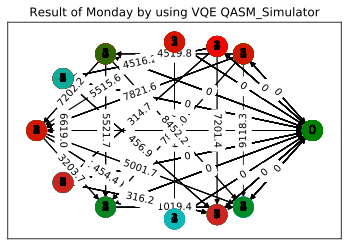

In [42]:
params2 = createScheduleResults(schedule2, edges, newMax, newMin) 
params3 = createScheduleResults(schedule3, edges, newMax, newMin)
params4 = createScheduleResults(schedule4, edges, newMax, newMin)
params5 = createScheduleResults(schedule5, edges, newMax, newMin)
params6 = createScheduleResults(schedule6, edges, newMax, newMin)
params7 = createScheduleResults(schedule7, edges, newMax, newMin)
params8 = createScheduleResults(schedule8, edges, newMax, newMin)
params9 = createScheduleResults(schedule9, edges, newMax, newMin)
params10 = createScheduleResults(schedule10, edges, newMax, newMin)

We plot comparative graphs between schedules:

No handles with labels found to put in legend.
/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


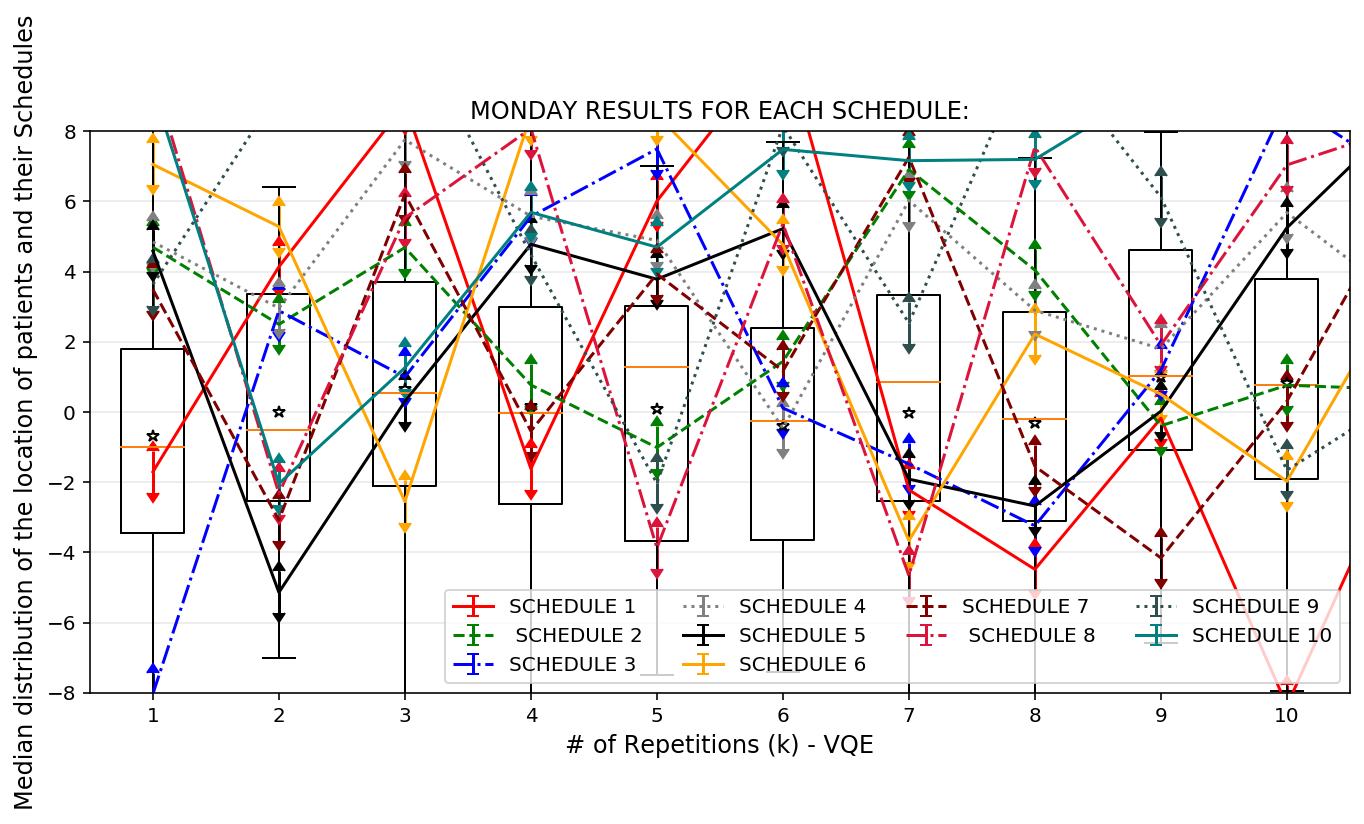

In [54]:
from matplotlib.patches import Polygon

#random_dists = ['VQE(1,3)', ' QAOA(1,3)', 'QAOA(2,3)', 'VQE(2,3)', 'QAOA(1,4)', 'VQE(1,4)']
random_dists = ['SCHEDULE 1', ' SCHEDULE 2', 'SCHEDULE 3', 'SCHEDULE 4', 'SCHEDULE 5', 'SCHEDULE 6','SCHEDULE 7', 
                ' SCHEDULE 8', 'SCHEDULE 9', 'SCHEDULE 10']

# Generate some random indices that we'll use to resample the original data
# arrays. For code brevity, just use the same random indices for each array
#bootstrap_indices = np.random.randint(0, N, N)

data = [
    params[0], params2[0],
    params3[0], params4[0],
    params5[0], params6[0],
    params7[0], params8[0],
    params9[0], params10[0],
]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Social Workers')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

dy = 0.6
yerr = np.linspace(0.05, 0.2, 10)
styles = ['-', '--', '-.', ':','-']
color= ['red', 'green', 'blue', 'grey','black','orange','maroon','crimson','darkslategrey','teal']
#print('xx',xx)
#print('lenght de xx',len(xx))
#print('lenght de Data',len(data[1]))
#print('data:',data)
upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5

"""
plt.errorbar(xx, data[1], yerr=dy,  label=random_dists[1])
plt.errorbar(xx, data[2]+.5, yerr=dy,  uplims=True, label=random_dists[2])
plt.errorbar(xx, data[3]+.1, yerr=dy,  uplims=True, lolims=True, label=random_dists[3])
plt.errorbar(xx, data[4]+.2, yerr=dy,  uplims=True, lolims=True, label=random_dists[4])
plt.errorbar(xx, data[5]+.3, yerr=dy,  uplims=True, lolims=True, label=random_dists[5])

plt.errorbar(xx,data[1], yerr=dy,mec='red', fmt='.k');
plt.errorbar(xx,data[2], yerr=dy,mec='cyan', fmt='.k');
plt.errorbar(xx,data[3], yerr=dy,mec='gray', fmt='.k');
plt.errorbar(xx,data[4], yerr=dy,mec='yellow', fmt='.k');
plt.errorbar(xx,data[5], yerr=dy, mec='blue',fmt='.k');
"""
plt.legend(loc='lower right')

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
#ax1.set_title('Comparison of Social Workers Problem Bootstrap Across Six Combinations in 2 Quantum Techniques',fontsize=12)
ax1.set_xlabel('# of Repetitions (k) - VQE',fontsize=12)
ax1.set_ylabel('Median distribution of the location of patients and their Schedules',fontsize=12)

# Now fill the boxes with desired colors
#box_colors = ['darkkhaki', 'royalblue']
box_colors = ['white', 'cyan']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    box_coords = np.column_stack([boxX, boxY])
    # Alternate between Dark Khaki and Royal Blue
  #  ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))   #I commented it!
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
       # ax1.plot(medianX, medianY, 'k')
    medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    ax1.plot(np.average(med.get_xdata()), np.average(data[i]), color='w', marker='*', markeredgecolor='k')
    xx = np.linspace(1, len(data[i]), len(data[i]))
    plt.errorbar(xx, 1+data[i]+.3*i, yerr=dy, color=color[i],ls=styles[i%5], uplims=True, lolims=True, label=random_dists[i])
    plt.legend(loc='lower right',ncol=4)
#plt.legend(loc='lower right')
#plt.legend(loc='lower center')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, num_boxes + 0.5)
top = 8
bottom = -8
ax1.set_ylim(bottom, top)
#ax1.set_xticklabels(np.repeat(random_dists, 1), rotation=0, fontsize=12)

#ax1.set_xticklabels(np.repeat(random_dists, 2), rotation=45, fontsize=12)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)

"""
pos = np.arange(num_boxes) + 1
upper_labels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], .95, upper_labels[tick],
             transform=ax1.get_xaxis_transform(),
             horizontalalignment='center', size='x-small',
             weight=weights[k], color=box_colors[k])

"""
# Finally, add a basic legend
#fig.text(0.80, 0.08, f'{N} Random Numbers', backgroundcolor=box_colors[0], color='black', weight='roman', size='x-small')
#fig.text(0.80, 0.045, 'IID Bootstrap Resample', backgroundcolor=box_colors[1], color='white', weight='roman', size='x-small')
#fig.text(0.80, 0.015, '*', color='white', backgroundcolor='silver', weight='roman', size='medium')
#fig.text(0.815, 0.013, ' Average Value', color='black', weight='roman', size='x-small')
%config InlineBackend.figure_format = 'retina'
plt.title("MONDAY RESULTS FOR EACH SCHEDULE:")
plt.show()
#print(data[4])

/Users/parfait/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


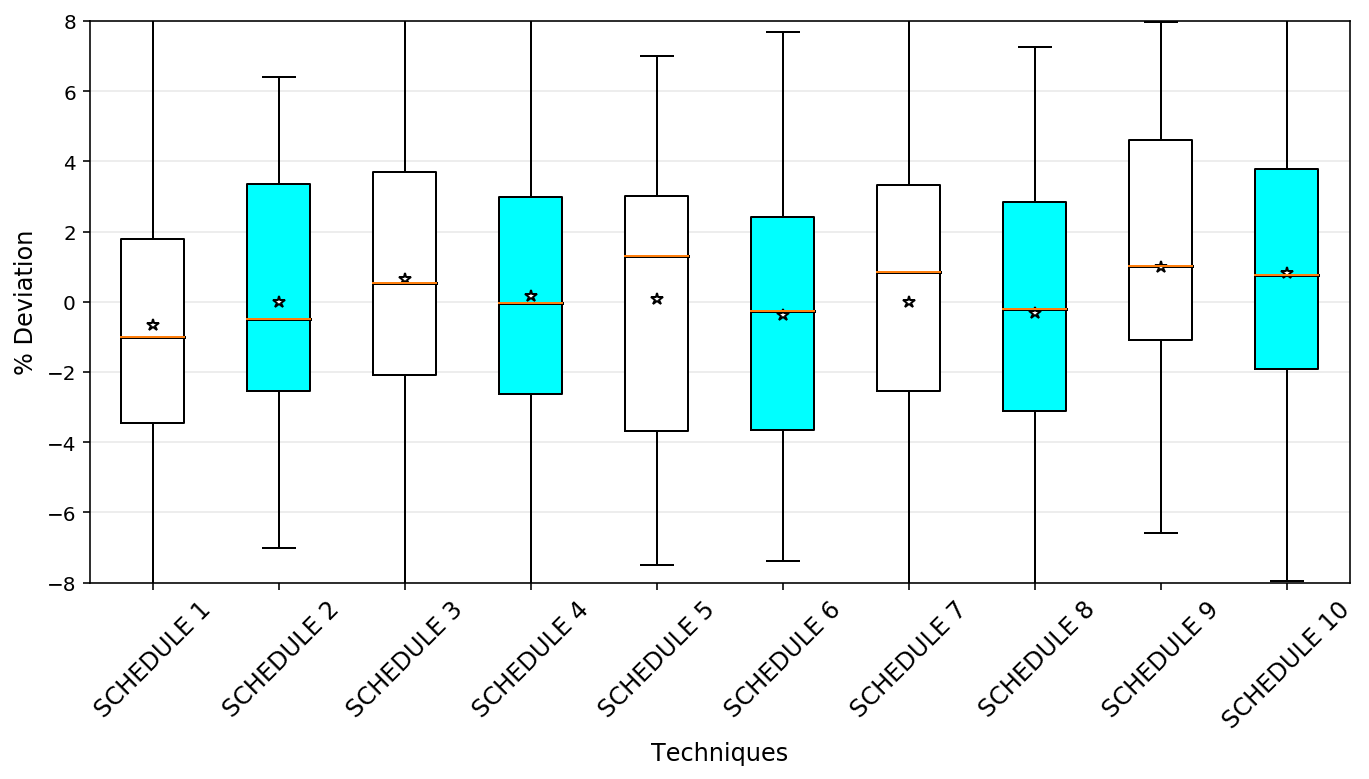

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Social Workers')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)

plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
#ax1.set_title('Comparison of Social Workers Problem Bootstrap Across Six Combinations in 2 Quantum Techniques',fontsize=12)
ax1.set_xlabel('Techniques',fontsize=12)
ax1.set_ylabel('% Deviation',fontsize=12)

# Now fill the boxes with desired colors
#box_colors = ['darkkhaki', 'royalblue']
box_colors = ['white', 'cyan']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    box_coords = np.column_stack([boxX, boxY])
    # Alternate between Dark Khaki and Royal Blue
    ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        ax1.plot(medianX, medianY, 'k')
    medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
   #ax1.plot(np.average(med.get_xdata()), np.average(data[i]), color='w', marker='*', markeredgecolor='k')
    ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
             color='w', marker='*', markeredgecolor='k')
   # plt.errorbar(xx, data[i]+.2*i, yerr=dy, color=color[i],ls=styles[i%5], uplims=True, lolims=True , label=random_dists[i])
   # plt.legend(loc='lower right',ncol=4)
#plt.legend(loc='lower right')
#plt.legend(loc='lower center')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, num_boxes + 0.5)
top = 8
bottom = -8
ax1.set_ylim(bottom, top)
#ax1.set_xticklabels(np.repeat(random_dists, 1), rotation=0, fontsize=12)

ax1.set_xticklabels(np.repeat(random_dists, 1), rotation=45, fontsize=12)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)

"""
pos = np.arange(num_boxes) + 1
upper_labels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], .95, upper_labels[tick],
             transform=ax1.get_xaxis_transform(),
             horizontalalignment='center', size='x-small',
             weight=weights[k], color=box_colors[k])

"""
# Finally, add a basic legend
#fig.text(0.80, 0.08, f'{N} Random Numbers', backgroundcolor=box_colors[0], color='black', weight='roman', size='x-small')
#fig.text(0.80, 0.045, 'IID Bootstrap Resample', backgroundcolor=box_colors[1], color='white', weight='roman', size='x-small')
#fig.text(0.80, 0.015, '*', color='white', backgroundcolor='silver', weight='roman', size='medium')
#fig.text(0.815, 0.013, ' Average Value', color='black', weight='roman', size='x-small')

%config InlineBackend.figure_format = 'retina'
plt.show()

# ANNEX (IN DEVELOPMENT):

We created a Dijkstra function that will offer us all the fastest paths to the different patients from the first patient that contains the matrix of vertices (at the beginning, it would be the patient with the earliest start time), TAKING INTO ACCOUNT THE NUMBER OF SOCIAL WORKERS AVAILABLE:

In [45]:
def to_be_visited(number_of_vertices, visited_and_distance):
    v = -10
    # Choosing the vertex with the minimum distance
    for index in range(number_of_vertices):
        if visited_and_distance[index][0] == 0 and (v < 0 or visited_and_distance[index][1] <= visited_and_distance[v][1]):
            v = index
    return v

def calculateDijkstra(vertices, edges):
    number_of_vertices = len(vertices[0])

    # Versioned from: https://www.educative.io/edpresso/how-to-implement-dijkstras-algorithm-in-python
    # The first element of the list inside visited_and_distance denotes if the vertex has been visited.
    # The second element of the list inside the visited_and_distance denotes the distance from the source.
    # The third element of the list inside visited_and_distance denotes the path taken to arrive to the destiny

    visited_and_distance = [[0, 0, []]]
    for i in range(number_of_vertices - 1):
        visited_and_distance.append([0, sys.maxsize, []])

    for vertex in range(1, number_of_vertices - 1):
        # Finding the next vertex to be visited.
        to_visit = to_be_visited(number_of_vertices, visited_and_distance)
        for neighbor_index in range(number_of_vertices):
            # Calculating the new distance for all unvisited neighbours
            # of the chosen vertex.
            if vertices[to_visit][neighbor_index] == 1 and visited_and_distance[neighbor_index][0] == 0:
                new_distance = visited_and_distance[to_visit][1] + edges[to_visit][neighbor_index]
                # Updating the distance of the neighbor if its current distance
                # is greater than the distance that has just been calculated
                if visited_and_distance[neighbor_index][1] > new_distance:
                    visited_and_distance[neighbor_index][1] = new_distance
                    visited_and_distance[neighbor_index][2].append(to_visit)
            # Visiting the vertex found earlier
            visited_and_distance[to_visit][0] = 1

    return visited_and_distance

In [46]:
def createPathsSocialworkersDijkstra(schedule, distancias, maxDistance, minDistance):
    pathSocialworker = []
   
    # We run the algorithm for each day to plan each day of the week
    for day in schedule:
        visits = []
        pathDay = []
       
        #We fill out an array with patients to visit from the current day in order from earliest to latest
        for j in schedule[day]:
            for k in j.getPatients():
                visit = timeSchedule(j.getStartTime().strftime('%H:%M'), j.getEndTime().strftime('%H:%M'))
                visit.addPatient(k)
                visits.append(visit)

        weights = []
        vertices = []
        indexMatrix = []
        sumCosts = 0

        # We create two matrices, one with the weights and the other with the valid addresses between vertices (depending on the
        # order of patients, the former may be related to those who come after him)
        for j in range(len(visits)):
            filaP = []
            filaV = []
            for k in range(len(visits)):
                filaP.append(sys.maxsize)
                filaV.append(0)

            weights.append(filaP)
            vertices.append(filaV)
            # This is necessary to map vertex with real patient
            indexMatrix.append(j)
        # We calculate weights taking into account the relationship between vertices previously explained
        calculateWeights(distancias, maxDistance, minDistance, visits, vertices, weights)
        plotWeights(weights, visits, day)
        
        while len(vertices) != 0:
            resultVisits = calculateDijkstra(vertices, weights)
            
            res = []
            indice = 0

            if len(resultVisits) > 1:
                res = resultVisits[:]
                res.sort(key=sortResult)
                indice = resultVisits.index(res[1])

                # We add final vertex to the result (which also adds it to res variable)
                resultVisits[indice][2].append(indice)
                res[1][2].sort()
                
                flag = 0
            else:
                flag = 1

            #CASE: initial node cannot link to another visit
            if flag or len(resultVisits[indice][2]) == 0:
                pathDay.append([ visits[indexMatrix[0]] ])
                vertices.pop(0)
                indexMatrix.pop(0)

                for popIndex in range(len(vertices)):
                    vertices[popIndex].pop(0)

            # CASE: A viable path has been found
            else:
                # We save the result of the Dijkstra method
                finalResult = resultVisits[indice][2][:]
                for realIndex in range(len(finalResult)):
                    valor = finalResult[realIndex]
                    finalResult[realIndex] = visits[indexMatrix[valor]]

                pathDay.append(finalResult)
                sumCosts = sumCosts + resultVisits[indice][1]

                # We ignore patients already visited and remove them from the index matrix
                for popIndex in range(len(vertices)):
                    countPop = 0
                    for temp in res[1][2]:
                        vertices[popIndex].pop(temp - countPop)
                        countPop = countPop + 1

                countPop = 0

                for popIndex in res[1][2]:
                    vertices.pop(popIndex - countPop)
                    indexMatrix.pop(popIndex - countPop)
                    countPop = countPop + 1


        pathSocialworker.append([pathDay, sumCosts, visits, weights])

    return pathSocialworker

Using Google OR-tools to solve Vehicle Routing:

In [47]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def print_solution(manager, routing, solution, visits):
    """Prints solution on console."""
    max_route_distance = 0

    for vehicle_id in range(N_SOCIALWORKERS):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0

        while not routing.IsEnd(index):

            plan_output += ' {} -> '.format(visits[manager.IndexToNode(index)].getName())
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            #print(previous_index, index)
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

def ORVehicleRouting(weights, visits):    
    data = weights
    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data[from_node][to_node]
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(weights), N_SOCIALWORKERS, 0)

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        sys.maxsize - 1,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)

    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution, visits)

In [48]:
def createPathsSocialworkersOR(schedule, distances, maxDistance, minDistance):
    pathSociaworkers = []
    # We run the algorithm for each day to plan each day of the week
    for day in schedule:
        patient0 = timeSchedule('9:00', '10:00')
        patient0.addPatient(0)
        visits = [patient0]
        pathDay = []
        #We fill out an array with patients to visit from the current day in order from earliest to latest
        for j in schedule[day]:
            for k in j.getPatients():
                visit = timeSchedule(j.getStartTime().strftime('%H:%M'), j.getEndTime().strftime('%H:%M'))
                visit.addPatient(k)
                visits.append(visit)

        weights = []
        vertices = []
        indexMatrix = []
        sumCosts = 0

        # We create two matrices, one with the weights and the other with the valid addresses between vertices (depending on the
        # order of patients, the former may be related to those who come after him)
        for j in range(len(visits)):
            rowP = []
            rowV = []
            for k in range(len(visits)):
                rowP.append(sys.maxsize)
                rowV.append(0)

            weights.append(rowP)
            vertices.append(rowV)

        # We calculate weights taking into account the relationship between vertices previously explained
        calculateWeights(distances, maxDistance, minDistance, visits, vertices, weights)
        #caminosEnfermeros.append([ORVehicleRouting(pesos), vertices, pesos, visits])
        ORVehicleRouting(weights, visits)
        
    return pathSociaworkers

In [49]:
createPathsSocialworkersOR(schedule1, edges, newMax, newMin)

Route for vehicle 0:
 0 ->  1 ->  5 -> 0
Distance of the route: 1513m

Route for vehicle 1:
 0 ->  4 ->  2 ->  3 -> 0
Distance of the route: 3373m

Maximum of the route distances: 3373m
Route for vehicle 0:
 0 ->  1 -> 0
Distance of the route: 0m

Route for vehicle 1:
 0 ->  2 ->  3 -> 0
Distance of the route: 621m

Maximum of the route distances: 621m
Route for vehicle 0:
 0 ->  1 ->  4 ->  3 -> 0
Distance of the route: 6372m

Route for vehicle 1:
 0 ->  2 -> 0
Distance of the route: 0m

Maximum of the route distances: 6372m
Route for vehicle 0:
 0 ->  1 -> 0
Distance of the route: 0m

Route for vehicle 1:
 0 ->  3 -> 0
Distance of the route: 0m

Maximum of the route distances: 0m
Route for vehicle 0:
 0 ->  1 ->  4 -> 0
Distance of the route: 1252m

Route for vehicle 1:
 0 ->  5 ->  3 -> 0
Distance of the route: 6056m

Maximum of the route distances: 6056m


[]